## Data Importing, Cleaning and Imputation

In [1]:
"""
Importing modules here
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# For specfic visualizations
from matplotlib.ticker import FuncFormatter
from joypy import joyplot

In [2]:
competition_clubs = pd.read_csv('../data/2024_12_20_16_12/competition_clubs.csv')
player_info = pd.read_csv('../data/2024_12_20_16_12/player_info.csv')
player_jersey_numbers = pd.read_csv('../data/2024_12_20_16_12/player_jersey_numbers.csv')
player_market_values = pd.read_csv('../data/2024_12_20_16_12/player_market_values.csv')
player_stats = pd.read_csv('../data/2024_12_20_16_12/player_stats.csv')

In [3]:
seasons = ['14/15', '15/16', '16/17', '17/18', '18/19',
           '19/20', '20/21', '21/22', '22/23', '23/24']

# Because of data limitations, need to manually state which clubs were
# promoted to first division for the first season listed in the data
promoted_clubs_for_first_season = {
    "Queens Park Rangers",
    "Leicester City",
    "Burnley FC",
    "Deportivo de La Coruña",
    "Córdoba CF",
    "SD Eibar",
    "1.FC Köln",
    "SC Paderborn 07",
    "US Palermo",
    "FC Empoli",
    "AC Cesena",
    "SM Caen",
    "FC Metz",
    "RC Lens"
}

#### _Data Corrections_

In [4]:
"""
Making youth team corrections in competition_clubs
"""
youth_team_corrections = {
    # England
    1010: (37993, "Watford FC U21"),
    2288: (33616, "Swansea City U21"),
    1039: (33727, "Queens Park Rangers U21"),
    1031: (92433, "Luton Town U21"),
    # Spain
    621: (6688, "Bilbao Athletic"),
    366: (7078, "Real Valladolid Promesas"),
    714: (10773, "RCD Espanyol B"),
    16795: (21550, "Recreativo Granada"),
    2448: (12331, "Sporting Atlético"),
    # Italy
    1025: (14848, "Bologna Primavera"),
    4102: (27531, "Carpi Primavera"),
    5: (10958, "AC Milan Primavera"),
    458: (11493, "Palermo Primavera"),
    800: (11998, "Atalanta Primavera"),
    862: (14845, "Chievo Primavera"),
    2722: (22276, "SPAL Primavera"),
    19: (14829, "Brescia Primavera"),
    1429: (20106, "Cesena Primavera"),
    # Germany
    533: (983, "TSG 1899 Hoffenheim II"),
    # France
    583: (6326, "Paris Saint-Germain U19"),
    995: (10850, "FC Nantes B"),
    1159: (10840, "AS Nancy-Lorraine B"),
    3558: (49984, "GFC Ajaccio U19"),
    14171: (28560, "Thonon Évian Grand Genève FC B")
}

other_team_corrections = {
    92878: 418, # Real Madrid C -> Real Madrid
    41107: 5, # Milan Futuro -> AC Milan
    41110: 800, # Atalanta U23 -> Atalanta
    41101: 506, # Juventus Next Gen -> Juventus
    7813: 1041, # Olympique Lyon U19 -> Olympique Lyon
    43570: 583, # PSG Espoirs -> PSG
    10851: 995, # FC Nantes U19 -> FC Nantes
    14626: 2288, # Swansea City U18 -> Swansea City
    14619: 1031, # Luton Town U18 -> Luton Town
    12805: 1039, # QPR U18 -> QPR
    10732: 1010, # Watford FC U18 -> Watford FC
    10841: 995, # AS Nancy U19 -> AS Nancy
}

def apply_corrections(row, corrections):
    club_id = row["club_id"]
    if club_id in corrections:
        row["youth_team_id"], row["youth_team_name"] = corrections[club_id]
    return row

In [5]:
competition_clubs = competition_clubs.apply(apply_corrections,
                                            axis=1,
                                            corrections=youth_team_corrections)
competition_clubs['youth_team_id'] = competition_clubs['youth_team_id'].astype('Int64')

In [6]:
"""
Fixing situation where young players are registered for their club's
youth teams despite possibly making appearances for the senior team
which may affect market value EDA.
"""
mapping_df = competition_clubs[['youth_team_id', 'club_id', 'club_name']]

merged_df = player_market_values.merge(
    mapping_df,
    left_on='club_id',
    right_on='youth_team_id',
    how='left',
    suffixes=('', '_mapped')
)

# Update club_id and club_name only where there is a match
merged_df['club_id'] = merged_df['club_id_mapped'].fillna(merged_df['club_id']).astype('Int64')
merged_df['club_name'] = merged_df['club_name_mapped'].fillna(merged_df['club_name'])
edited_player_market_values = merged_df.drop(columns=['club_id_mapped', 'club_name_mapped', 'youth_team_id'])

# Verifying change
print("[BEFORE] # of observations for Real Madrid & Real Madrid Castilla: ",
      len(player_market_values[player_market_values['club_id'] == 418]),
      ", ",
      len(player_market_values[player_market_values['club_id'] == 6767]))
print("[AFTER] # of observations for Real Madrid & Real Madrid Castilla: ",
      len(edited_player_market_values[edited_player_market_values['club_id'] == 418]),
      ", ",
      len(edited_player_market_values[edited_player_market_values['club_id'] == 6767]))

# Also updating instances of alternate teams using `other_team_corrections` dictionary (not changing club_name however)
edited_player_market_values['club_id'] = edited_player_market_values['club_id'].replace(other_team_corrections)

[BEFORE] # of observations for Real Madrid & Real Madrid Castilla:  1027 ,  586
[AFTER] # of observations for Real Madrid & Real Madrid Castilla:  1613 ,  0


In [7]:
"""
Fixing competition_clubs so it doesn't have an issue when merging
"""
display(competition_clubs.head())

# Step 1: Split the 'season_id(s)' column and explode it into individual rows
expanded_competition_clubs = competition_clubs.copy()
expanded_competition_clubs['season_id(s)'] = expanded_competition_clubs['season_id(s)'].astype(str).str.split(',')  # Split the string into lists
expanded_competition_clubs = expanded_competition_clubs.explode('season_id(s)')

# Step 2: Convert season_id(s) to the desired format (e.g., 2023 -> '23/24')
expanded_competition_clubs['season_id(s)'] = expanded_competition_clubs['season_id(s)'].astype(int)  # Ensure it's numeric for manipulation
expanded_competition_clubs['season_id(s)'] = expanded_competition_clubs['season_id(s)'].apply(lambda x: f"{str(x)[-2:]}/{str(x + 1)[-2:]}")

# Step 3: Rename the column to 'season'
expanded_competition_clubs.rename(columns={'season_id(s)': 'season'}, inplace=True)
expanded_competition_clubs.reset_index(drop=True, inplace=True)

display(expanded_competition_clubs.head(11))

competition_id                                       season_id(s)  club_id  \
0            ES1  2023,2022,2021,2020,2019,2018,2017,2016,2015,2014      131   
1            ES1                 2023,2021,2020,2019,2016,2015,2014    16795   
2            ES1  2023,2022,2021,2020,2019,2018,2017,2016,2015,2014      368   
3            ES1  2023,2022,2021,2020,2019,2018,2017,2016,2015,2014     1050   
4            ES1  2023,2022,2021,2020,2019,2018,2017,2016,2015,2014      418   

       club_name  youth_team_id       youth_team_name  
0   FC Barcelona           2464  FC Barcelona Atlètic  
1     Granada CF          21550    Recreativo Granada  
2     Sevilla FC           8519      Sevilla Atlético  
3  Villarreal CF          11972       Villarreal CF B  
4    Real Madrid           6767  Real Madrid Castilla

competition_id season  club_id     club_name  youth_team_id  \
0             ES1  23/24      131  FC Barcelona           2464   
1             ES1  22/23      131  FC Barcelona           2464   
2             ES1  21/22      131  FC Barcelona           2464   
3             ES1  20/21      131  FC Barcelona           2464   
4             ES1  19/20      131  FC Barcelona           2464   
5             ES1  18/19      131  FC Barcelona           2464   
6             ES1  17/18      131  FC Barcelona           2464   
7             ES1  16/17      131  FC Barcelona           2464   
8             ES1  15/16      131  FC Barcelona           2464   
9             ES1  14/15      131  FC Barcelona           2464   
10            ES1  23/24    16795    Granada CF          21550   

         youth_team_name  
0   FC Barcelona Atlètic  
1   FC Barcelona Atlètic  
2   FC Barcelona Atlètic  
3   FC Barcelona Atlètic  
4   FC Barcelona Atlètic  
5   FC Barcelona Atlètic  
6   FC Barcelona Atlètic  
7   FC Barcelona Atlètic  
8   FC Barcelona Atlètic  
9   FC Barcelona Atlètic  
10    Recreativo Granada

#### _Obtaining Full Dataset_

In [8]:
"""
Adding `is_newly_promoted` column for newly promoted teams
"""
expanded_competition_clubs['season'] = pd.Categorical(expanded_competition_clubs['season'], categories=seasons, ordered=True)
expanded_competition_clubs.sort_values(['club_id', 'season'], inplace=True)

existing_pairs = set(zip(expanded_competition_clubs['club_id'], expanded_competition_clubs['season']))
expanded_competition_clubs['prev_season'] = expanded_competition_clubs['season'].apply(
    lambda s: seasons[seasons.index(s) - 1]
    if seasons.index(s) > 0 else None
)
expanded_competition_clubs['is_newly_promoted'] = expanded_competition_clubs.apply(
    lambda row: (row['prev_season'] is None) or 
                (row['club_id'], row['prev_season']) not in existing_pairs,
    axis=1
)

mask_first_season = (expanded_competition_clubs['season'] == seasons[0])
expanded_competition_clubs.loc[mask_first_season, 'is_newly_promoted'] = expanded_competition_clubs \
                                                                            .loc[mask_first_season, 'club_name'] \
                                                                            .isin(promoted_clubs_for_first_season)

if 'prev_season' in expanded_competition_clubs.columns:
    expanded_competition_clubs.drop(['prev_season'], axis=1, inplace=True)

In [9]:
"""
Doing the data merges here to get the full dataset with I'll be working with
"""
print("Table for expanded_competition_clubs:")
display(expanded_competition_clubs.head())
print("Table for player_info:")
display(player_info.head())
print("Table for player_jersey_numbers:")
display(player_jersey_numbers.head())
print("Table for edited_player_market_values:")
display(edited_player_market_values.head())
print("Table for player_stats:")
display(player_stats.head())

# NOTE: null values pertaining to the top 5 leagues
# here are largely of players who didn't make an appearance
# but still had a registered jersey number
print()
print("Table built so far:")

player_markt_vals_jnumbs = edited_player_market_values.merge(
    player_jersey_numbers,
    on=['season', 'club_id', 'player_id'],
    how='left'
)

player_markt_vals_jnumbs_info = player_markt_vals_jnumbs.merge(
    player_info,
    on=['player_id'],
    how='left'
)

players_topfive = player_markt_vals_jnumbs_info.merge(
    expanded_competition_clubs,
    on=['season', 'club_id'],
    how='outer',
    suffixes=['', '_topfive']
)
players_topfive.drop(['youth_team_id', 'youth_team_name', 'club_name_topfive'], axis=1, inplace=True)

players_df = players_topfive.merge(
    player_stats,
    on=['season', 'competition_id', 'club_id', 'player_id'],
    how='left'
)

display(players_df.head())

Table for expanded_competition_clubs:


competition_id season  club_id  club_name  youth_team_id youth_team_name  \
488             L1  14/15        3  1.FC Köln            438    1.FC Köln II   
487             L1  15/16        3  1.FC Köln            438    1.FC Köln II   
486             L1  16/17        3  1.FC Köln            438    1.FC Köln II   
485             L1  17/18        3  1.FC Köln            438    1.FC Köln II   
484             L1  19/20        3  1.FC Köln            438    1.FC Köln II   

     is_newly_promoted  
488               True  
487              False  
486              False  
485              False  
484               True

Table for player_info:


player_id          player_name  \
0     944847       Edvin Bongemba   
1     792380  Aleksandar Pavlovic   
2     804548     Baptiste Mouazan   
3     430503       Jacopo Da Riva   
4     516407      Bojan Radulović   

                                           image_url date_of_birth height  \
0                                                NaN  Jan 14, 2004  1,88m   
1  https://img.a.transfermarkt.technology/portrai...   May 3, 2004  1,88m   
2  https://img.a.transfermarkt.technology/portrai...  Sep 27, 2001  1,74m   
3  https://img.a.transfermarkt.technology/portrai...  Oct 27, 2000  1,87m   
4  https://img.a.transfermarkt.technology/portrai...  Dec 29, 1999  1,92m   

  primary_citizenship secondary_citizenship       main_position  \
0              France              DR Congo  Attacking Midfield   
1             Germany                Serbia  Defensive Midfield   
2              France                   NaN    Central Midfield   
3               Italy                   NaN    Central Midfield   
4              Serbia                 Spain      Centre-Forward   

                          other_positions preferred_foot outfitter  
0           Left Winger, Central Midfield          right       NaN  
1                        Central Midfield           both      Nike  
2                      Attacking Midfield          right       NaN  
3  Defensive Midfield, Attacking Midfield           both       NaN  
4                                     NaN          right    adidas

Table for player_jersey_numbers:


player_id season  club_id  jersey_number
0     944847  23/24     6572              8
1     944847  23/24     6572             11
2     944847  23/24     6572             13
3     944847  23/24     6572             14
4     944847  22/23      969             32

Table for edited_player_market_values:


player_id          date  club_id            club_name    value season
0     944847  Jun 27, 2023      969    Montpellier HSC B     €50k  22/23
1     944847  Jun 28, 2024      969    Montpellier HSC B      NaN  23/24
2     792380   Aug 1, 2023       27  FC Bayern Munich II    €200k  23/24
3     792380  Dec 14, 2023       27        Bayern Munich   €2.00m  23/24
4     792380  Mar 27, 2024       27        Bayern Munich  €25.00m  23/24

Table for player_stats:


player_id competition_id           competition_name season  club_id  \
0     944847           C3CM        National 3 - Grp. A  23/24     6572   
1     944847           F19F  National U19 - Tour final  22/23    10852   
2     944847           C3OC             N3 - Occitanie  22/23     6572   
3     944847            FR1                    Ligue 1  22/23      969   
4     944847           F19D      National U19 - Grp. D  22/23    10852   

   appearances minutes_played  goals  assists  yellow_cards  red_cards  
0         22.0         1.423'    6.0      NaN           4.0        NaN  
1          1.0            12'    NaN      NaN           NaN        NaN  
2         16.0         1.192'    1.0      1.0           2.0        NaN  
3          NaN            NaN    NaN      NaN           NaN        NaN  
4          2.0           166'    NaN      NaN           2.0        NaN


Table built so far:


player_id          date  club_id            club_name   value season  \
0       1791   Oct 4, 2004        2  1.FC Kaiserslautern  €1.00m  04/05   
1       1791  Mar 31, 2005        2  1.FC Kaiserslautern  €1.25m  04/05   
2      13686   Oct 4, 2004        3            1.FC Köln    €75k  04/05   
3      13686  Oct 16, 2004        3            1.FC Köln   €200k  04/05   
4      15185   Oct 4, 2004        3            1.FC Köln  €3.50m  04/05   

   jersey_number     player_name  \
0           19.0  Halil Altıntop   
1           19.0  Halil Altıntop   
2           29.0   Thomas Bröker   
3           29.0   Thomas Bröker   
4           10.0  Lukas Podolski   

                                           image_url date_of_birth  ...  \
0  https://img.a.transfermarkt.technology/portrai...   Dec 8, 1982  ...   
1  https://img.a.transfermarkt.technology/portrai...   Dec 8, 1982  ...   
2  https://img.a.transfermarkt.technology/portrai...  Jan 22, 1985  ...   
3  https://img.a.transfermarkt.technology/portrai...  Jan 22, 1985  ...   
4  https://img.a.transfermarkt.technology/portrai...   Jun 4, 1985  ...   

  outfitter competition_id is_newly_promoted competition_name appearances  \
0       NaN            NaN               NaN              NaN         NaN   
1       NaN            NaN               NaN              NaN         NaN   
2    adidas            NaN               NaN              NaN         NaN   
3    adidas            NaN               NaN              NaN         NaN   
4    adidas            NaN               NaN              NaN         NaN   

  minutes_played goals assists yellow_cards red_cards  
0            NaN   NaN     NaN          NaN       NaN  
1            NaN   NaN     NaN          NaN       NaN  
2            NaN   NaN     NaN          NaN       NaN  
3            NaN   NaN     NaN          NaN       NaN  
4            NaN   NaN     NaN          NaN       NaN  

[5 rows x 26 columns]

In [10]:
"""
NOTES:
- Since dataframe has time-series data, the player stats refer to the
  player's season stats and NOT their stats upto `date`.
"""
print(players_df.info())
print()
print(players_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261110 entries, 0 to 261109
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   player_id              261110 non-null  int64  
 1   date                   261110 non-null  object 
 2   club_id                261110 non-null  Int64  
 3   club_name              261110 non-null  object 
 4   value                  256527 non-null  object 
 5   season                 261110 non-null  object 
 6   jersey_number          241092 non-null  float64
 7   player_name            261110 non-null  object 
 8   image_url              255044 non-null  object 
 9   date_of_birth          260512 non-null  object 
 10  height                 256095 non-null  object 
 11  primary_citizenship    261110 non-null  object 
 12  secondary_citizenship  95164 non-null   object 
 13  main_position          261052 non-null  object 
 14  other_positions        188833 non-nu

#### _Cleaning Dataframe_

In [11]:
'''
IMPORTANT: Need to edit depending on number of seasons (keep one extra season for cursed/blessed analysis)
'''
list_of_seasons = ['13/14', '14/15', '15/16', '16/17', '17/18', '18/19',
                   '19/20', '20/21', '21/22', '22/23', '23/24']

In [12]:
"""
Cleaning up the dataframe and re-organizing it
"""
# Updating datatypes
stats_columns = ['appearances', 'minutes_played', 'goals', 'assists', 'yellow_cards', 'red_cards']
categorical_columns = ['season', 'competition_id', 'competition_name', 'club_name', 'main_position',
                       'primary_citizenship', 'secondary_citizenship', 'preferred_foot', 'outfitter']

clean_players_df = players_df[players_df['season'].isin(list_of_seasons)].copy() # Only taking the 10 seasons from 14/15-23/24 (+1 previous season for analysis)

# Fix missing competition_names even though competition_id exists; Merge issues
valid_pairs = clean_players_df.dropna(subset=['competition_id', 'competition_name'])
mapping = valid_pairs.drop_duplicates('competition_id').set_index('competition_id')['competition_name'] # Create a mapping from existing valid pairs
mask = clean_players_df['competition_id'].notna() & clean_players_df['competition_name'].isna()
clean_players_df.loc[mask, 'competition_name'] = clean_players_df.loc[mask, 'competition_id'].map(mapping)

# Renaming competitions to "Outside Top 5" as analysis is focused on Top 5 leagues
null_mask = clean_players_df['competition_id'].isna() & clean_players_df['competition_name'].isna()
clean_players_df.loc[null_mask, ['competition_id', 'competition_name']] = ['OUT', 'Outside Top 5']

# Renaming columns
clean_players_df.rename(columns={
                            'date': 'date_assessed',
                            'value': 'market_value_euros',
                            'height': 'height_meters'
                        },
                        inplace=True)

# Adjusting market_value_euros, height_meters, minutes_played
clean_players_df['market_value_euros'] = (
    clean_players_df['market_value_euros']
    .str.replace('€', '', regex=False)
    .str.replace('m', 'e6', regex=False)
    .str.replace('k', 'e3', regex=False)
    .apply(pd.to_numeric, errors='coerce')
    .astype('Int64')
)
clean_players_df['height_meters'] = (
    clean_players_df['height_meters']
    .str.replace(',', '.', regex=False)
    .str.replace('m', '', regex=False)
    .astype(float)
)
clean_players_df['minutes_played'] = clean_players_df['minutes_played'].str.replace("[.']", "", regex=True)

clean_players_df[['date_of_birth', 'date_assessed']] = clean_players_df[['date_of_birth', 'date_assessed']].apply(pd.to_datetime, errors='coerce')
for col in stats_columns:
    clean_players_df[col] = clean_players_df[col].astype('Int64')
clean_players_df['jersey_number'] = clean_players_df['jersey_number'].astype('Int64') # Converting jersey numbers to Int type
for col in categorical_columns:
    clean_players_df[col] = clean_players_df[col].astype('category')

clean_players_df['season'] = clean_players_df['season'].cat.reorder_categories(
    new_categories=list_of_seasons,
    ordered=True
)
clean_players_df['competition_name'] = clean_players_df['competition_name'].cat.reorder_categories(
    new_categories=['Premier League', 'LaLiga', 'Bundesliga', 'Serie A', 'Ligue 1', 'Outside Top 5'],
    ordered=False
)

# Creating an age when assessed market_value was assessed
clean_players_df['age_when_assessed'] = ((clean_players_df['date_assessed'] - clean_players_df['date_of_birth']).dt.days // 365).astype('Int64')

# Reorder the columns
column_order = [
    'season', 'competition_id', 'competition_name', 'club_id', 'club_name',
    'player_id', 'player_name', 'date_of_birth', 'height_meters', 'primary_citizenship', 'secondary_citizenship',
    'main_position', 'other_positions', 'preferred_foot', 'outfitter', 'jersey_number', 'is_newly_promoted',
    'appearances', 'minutes_played', 'goals', 'assists', 'yellow_cards', 'red_cards',
    'market_value_euros', 'date_assessed', 'age_when_assessed', 'image_url'
]
clean_players_df = clean_players_df[column_order]

In [13]:
"""
Cases where a player wore multiple jersey numbers over the season (largely a Ligue 1 problem, addressed later)
"""
clean_players_df.drop_duplicates(subset=['season', 'competition_id', 'club_id', 'player_id', 'date_assessed'],
                                 keep='first',
                                 inplace=True)

In [14]:
"""
Dealing with null values
"""
# Filling null values for player stats with 0
clean_players_df[stats_columns] = clean_players_df[stats_columns].fillna(0)

# Dropping low null counts for EDA purposes
clean_players_df.dropna(
    subset=['main_position', 'date_of_birth', 'date_assessed'],
    inplace=True
)

# Function for imputing null market value based on the other closest market value assessment by date
def fill_missing_market_values(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(by=['player_id', 'date_assessed'], inplace=True)
    missing_values_df = df[df['market_value_euros'].isna()]

    for player_id in missing_values_df['player_id'].unique():
        player_rows = df[df['player_id'] == player_id]
        missing_rows = player_rows[player_rows['market_value_euros'].isna()]

        for i, row in missing_rows.iterrows():
            date_assessed = row['date_assessed']
            prev_row = player_rows[(player_rows['date_assessed'] < date_assessed) & (player_rows['market_value_euros'].notna())] # Find the closest previous row (if any)
            next_row = player_rows[(player_rows['date_assessed'] > date_assessed) & (player_rows['market_value_euros'].notna())] # Find the closest next row (if any)

            if not prev_row.empty and not next_row.empty: # If both previous and next rows exist, choose the closer one
                prev_date = prev_row['date_assessed'].values[-1]
                next_date = next_row['date_assessed'].values[0]

                if abs(date_assessed - prev_date) <= abs(next_date - date_assessed):
                    df.at[i, 'market_value_euros'] = prev_row['market_value_euros'].values[-1]
                else:
                    df.at[i, 'market_value_euros'] = next_row['market_value_euros'].values[0]

            elif not prev_row.empty: # If only previous row exists, use it
                df.at[i, 'market_value_euros'] = prev_row['market_value_euros'].values[-1]
            elif not next_row.empty: # If only next row exists, use it
                df.at[i, 'market_value_euros'] = next_row['market_value_euros'].values[0]
    return df

clean_players_df = fill_missing_market_values(clean_players_df)
clean_players_df.dropna(subset=['market_value_euros'], inplace=True) # dropping player's with only 1 MV observation their entire career

In [15]:
# Defining previous market value for cursed/blessed jersey analysis and converting to category for seasons
clean_players_df[['prev_club_id', 'prev_market_value', 'prev_date_assessed']] = clean_players_df \
                                                                                    .groupby('player_id')[['club_id', 'market_value_euros', 'date_assessed']] \
                                                                                    .shift(1)
clean_players_df = clean_players_df.drop(clean_players_df[clean_players_df['season'] == '13/14'].index)

if '13/14' in list_of_seasons:
    list_of_seasons.remove('13/14')
clean_players_df['season'] = clean_players_df['season'].cat.remove_unused_categories()

clean_players_df['season'] = clean_players_df['season'].cat.reorder_categories(
    new_categories=list_of_seasons,
    ordered=True
)

# Filling missing previous market values with same value as current as not to affect analysis
clean_players_df['prev_club_id'] = clean_players_df['prev_club_id'].fillna(clean_players_df['club_id'])
clean_players_df['prev_market_value'] = clean_players_df['prev_market_value'].fillna(clean_players_df['market_value_euros'])
clean_players_df['prev_date_assessed'] = clean_players_df['prev_date_assessed'].fillna(clean_players_df['date_assessed'])

In [16]:
'''
Left with null values for jersey numbers in situations
where market value was assessed for a player before they left for another club,
so they don't have any jersey number assigned to them and newly promoted team
for all teams outside the top 5 leagues
'''
print(clean_players_df.info())
print()
print(clean_players_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 180443 entries, 51937 to 245108
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   season                 180443 non-null  category      
 1   competition_id         180443 non-null  category      
 2   competition_name       180443 non-null  category      
 3   club_id                180443 non-null  Int64         
 4   club_name              180443 non-null  category      
 5   player_id              180443 non-null  int64         
 6   player_name            180443 non-null  object        
 7   date_of_birth          180443 non-null  datetime64[ns]
 8   height_meters          177870 non-null  float64       
 9   primary_citizenship    180443 non-null  category      
 10  secondary_citizenship  64274 non-null   category      
 11  main_position          180443 non-null  category      
 12  other_positions        130683 non-null  objec

#### _Jersey Numbers EDA_

In [17]:
# Matching it with logo colors
competition_colors = {
    'Premier League': '#38003c',
    'LaLiga': '#ffab44',
    'Serie A': '#0578FF',
    'Bundesliga': '#D10214',
    'Ligue 1': '#CDFB0A',
    'Outside Top 5': '#808080'
}

jersey_num_bins  age_when_assessed
0            1-11          26.447757
1           12-25          25.890346
2             26+          22.885479

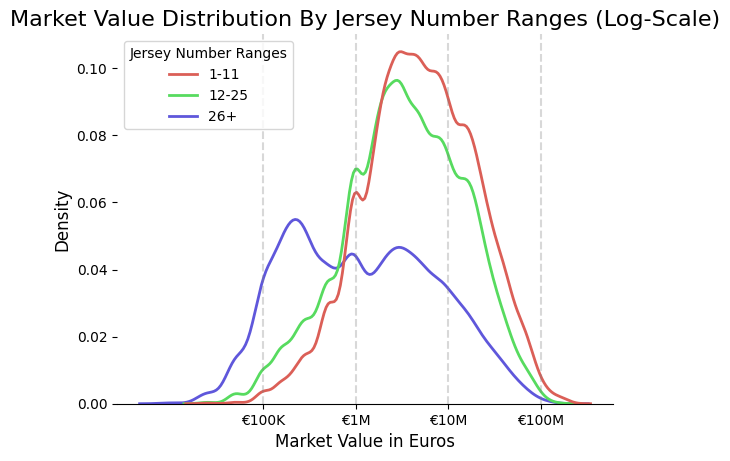

In [18]:
"""
Distribution of numbers (1-11), (12-25), vs the rest of the numbers in terms of market value
"""
# Creating dataset
custom_bins = [0, 11, 25, np.inf]
bin_labels = ['1-11', '12-25', '26+']

jerseynum_dist_viz_df = clean_players_df[clean_players_df['competition_name'] != 'Outside Top 5'].copy()
jerseynum_dist_viz_df['log_market_value'] = np.log(jerseynum_dist_viz_df['market_value_euros'])
jerseynum_dist_viz_df['jersey_num_bins'] = pd.cut(
    jerseynum_dist_viz_df['jersey_number'], bins=custom_bins, labels=bin_labels
)

display(jerseynum_dist_viz_df.groupby('jersey_num_bins', observed=True).agg({'age_when_assessed' : 'mean'}).reset_index())

# Plotting KDE
ax = sns.kdeplot(
    data=jerseynum_dist_viz_df,
    x='log_market_value',
    hue='jersey_num_bins',
    palette='hls',
    linewidth=2
)

plt.title('Market Value Distribution By Jersey Number Ranges (Log-Scale)', fontsize=16)
plt.xlabel('Market Value in Euros', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Setting custom ticks for the x-axis at (100K, 1M, 10M, 100M)
x_ticks = [np.log(100000), np.log(1000000), np.log(10000000), np.log(100000000)]
x_tick_labels = ['€100K', '€1M', '€10M', '€100M']
plt.xticks(x_ticks, x_tick_labels)

sns.despine(left=True)
plt.grid(False)
for tick in x_ticks:
    plt.axvline(x=tick, color='gray', linestyle='--', alpha=0.3)

handles, labels = ax.get_legend_handles_labels()
if len(handles) == 0:
    from matplotlib.lines import Line2D
    colors = sns.color_palette('hls', n_colors=3)
    handles = [Line2D([0], [0], color=colors[i], lw=2) for i in range(3)]
    labels = bin_labels

plt.legend(
    handles=handles,
    labels=labels,
    title="Jersey Number Ranges",
)
plt.show()

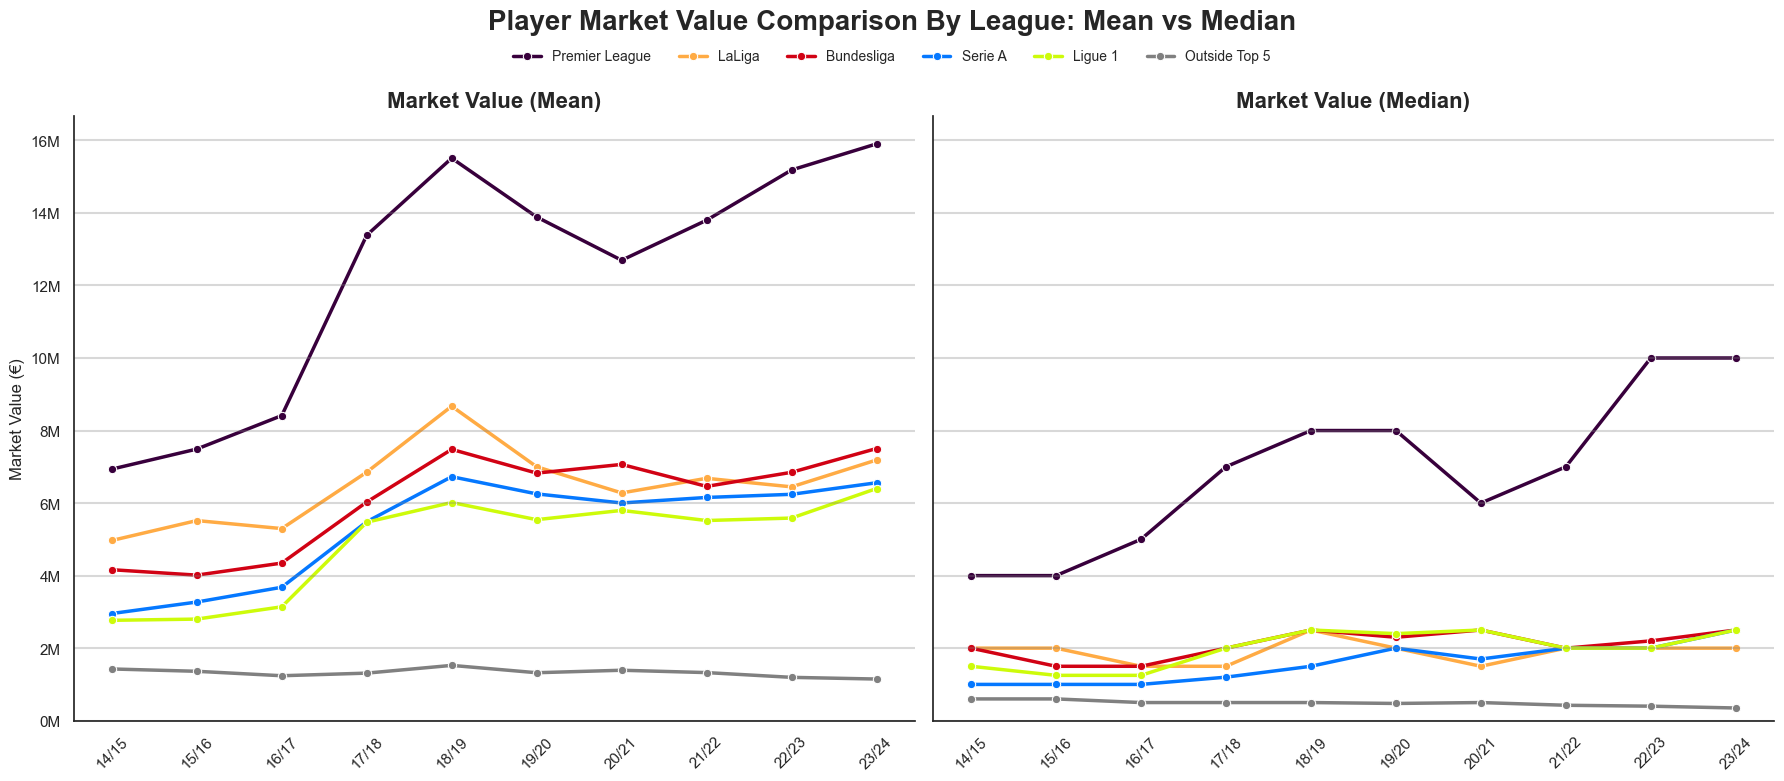

In [19]:
"""
Line graph of average (and median) market values by league over the past 10 seasons
"""
# Setting up the dataframe
markt_val_viz_df = clean_players_df.drop_duplicates(subset=['season', 'competition_id', 'club_id', 'player_id'],
                                                    keep='last') # Keeping the final market value for a player during a season
markt_val_agg = markt_val_viz_df.groupby(['competition_name', 'season'], observed=True)['market_value_euros'].agg(['mean', 'median']).reset_index()


sns.set_theme(style="white", palette="muted")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Left plot - MEAN
sns.lineplot(
    data=markt_val_agg,
    x='season',
    y='mean',
    hue='competition_name',
    marker='o',
    linewidth=2.5,
    palette=competition_colors,
    ax=ax1,
)
ax1.set_title("Market Value (Mean)", fontsize=16, fontweight='bold')
ax1.set_xlabel("")
ax1.set_ylabel("Market Value (€)", fontsize=12)

# Right plot - MEDIAN
sns.lineplot(
    data=markt_val_agg,
    x='season',
    y='median',
    hue='competition_name',
    marker='o',
    linewidth=2.5,
    palette=competition_colors,
    ax=ax2,
    legend=False  # Share single legend
)
ax2.set_title("Market Value (Median)", fontsize=16, fontweight='bold')
ax2.set_xlabel("")
ax2.set_ylabel("")

# Shared formatting
for ax in (ax1, ax2):
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
    ax.set_ylim(bottom=0)

    # Add grid lines
    for ytick in ax.get_yticks():
        ax.axhline(y=ytick, color='gray', linestyle='-', alpha=0.3)
    sns.despine(left=False, bottom=False, right=True, top=True)

# Main title and shared legend
fig.suptitle("Player Market Value Comparison By League: Mean vs Median", 
             fontsize=20,
             fontweight='bold',
             y=.975)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.94),
           ncol=len(labels),
           frameon=False,
           fontsize=10)
ax1.get_legend().remove()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

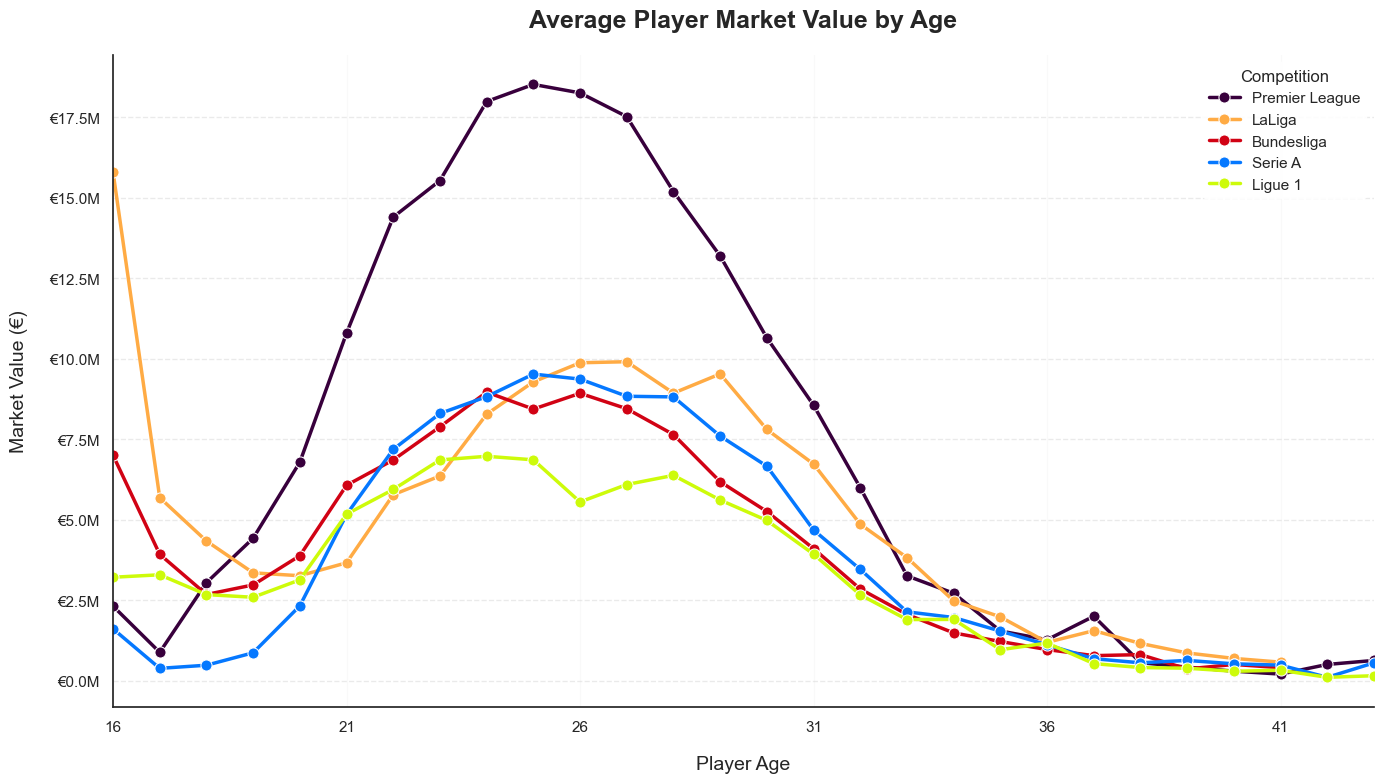

In [20]:
"""
Line graph of average market values by age for all 5 leagues
"""
# Setting up the dataframe
age_val_viz_df = clean_players_df.drop_duplicates(
    subset=['season', 'competition_id', 'club_id', 'player_id'],
    keep='last'
)
age_val_viz_df = age_val_viz_df[age_val_viz_df['competition_name'] != 'Outside Top 5']
age_val_agg = age_val_viz_df.groupby(['competition_name', 'age_when_assessed'], observed=True)['market_value_euros'].mean().reset_index()

# Create single plot figure
plt.figure(figsize=(14, 8))
ax = sns.lineplot(
    data=age_val_agg,
    x='age_when_assessed',
    y='market_value_euros',
    hue='competition_name',
    marker='o',
    linewidth=2.5,
    palette=competition_colors,
    markersize=8
)

# Title and labels
plt.title("Average Player Market Value by Age", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Player Age", fontsize=14, labelpad=15)
plt.ylabel("Market Value (€)", fontsize=14, labelpad=15)

# Format y-axis as millions
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"€{x/1e6:.1f}M"))

# Set x-axis ticks and limits
min_age = age_val_agg['age_when_assessed'].min()
max_age = age_val_agg['age_when_assessed'].max()
plt.xticks(range(min_age, max_age+1, 5))
plt.xlim(min_age, max_age)

# Add grid lines
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.grid(True, axis='x', alpha=0.1)

# Legend customization
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:-1], labels[:-1],
    title='Competition',
    frameon=True,
    framealpha=0.9,
    edgecolor='white',
    loc='upper right'
)

sns.despine()
plt.tight_layout()
plt.show()

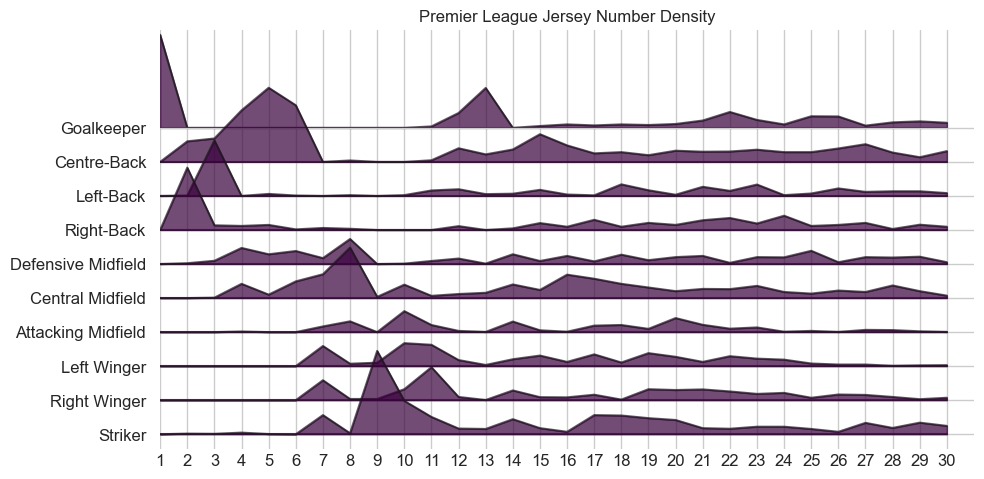

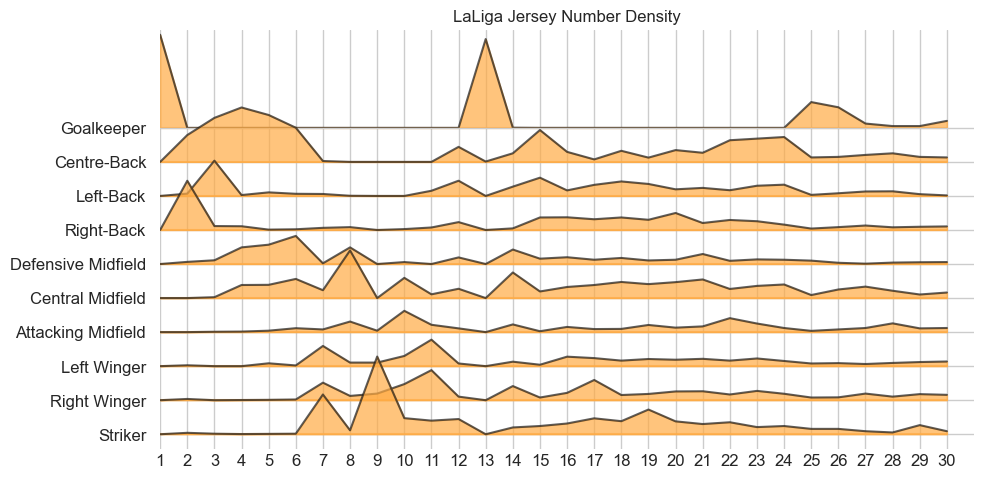

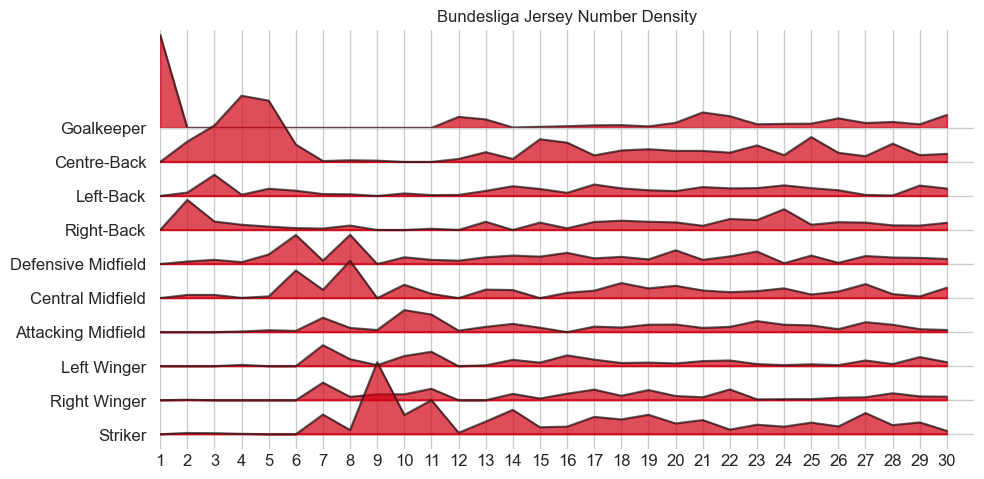

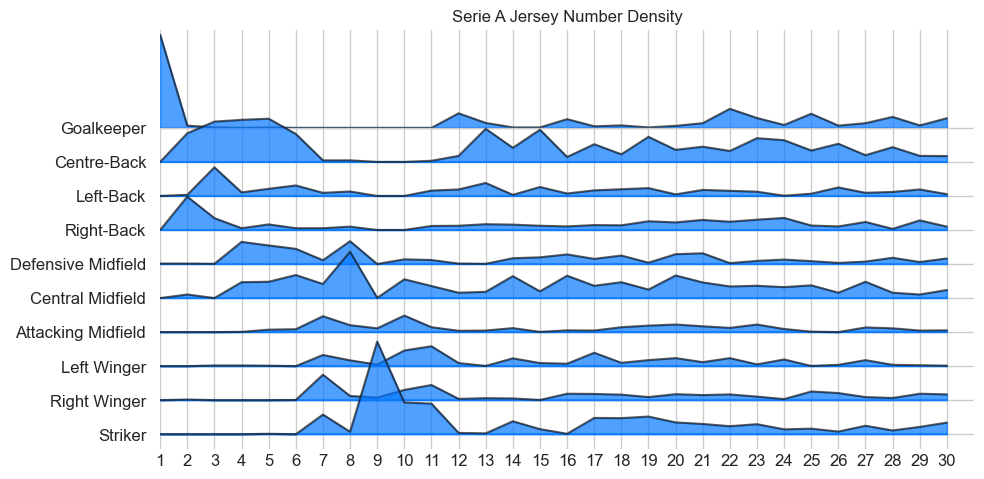

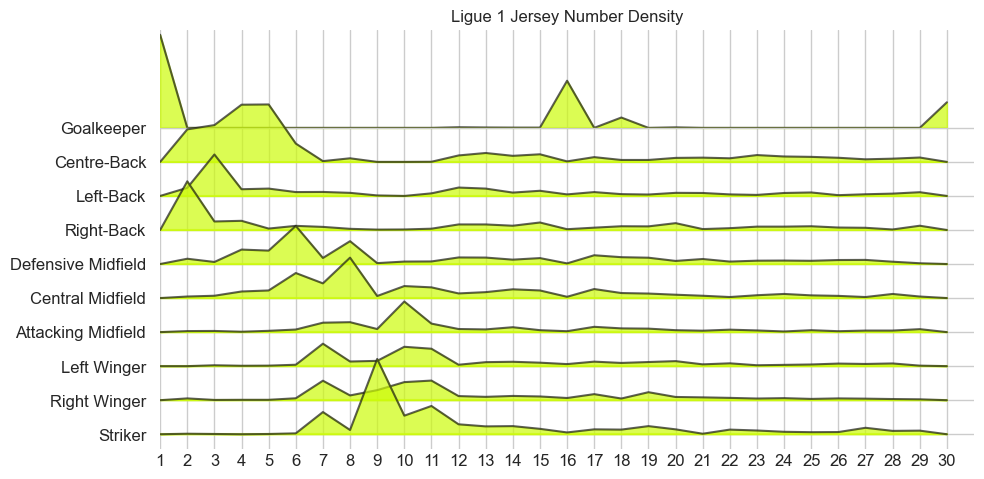

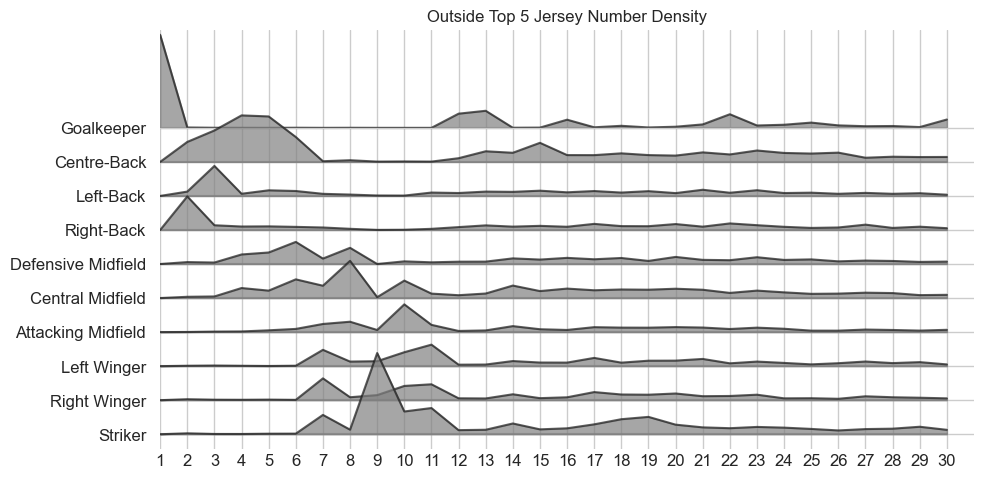

In [21]:
"""
Distribution chart of jersey numbers and player position
"""
general_position_map = {
    'Goalkeeper': 'Goalkeeper',
    'Centre-Back': 'Centre-Back',
    'Left-Back': 'Left-Back',
    'Right-Back': 'Right-Back',
    'Defensive Midfield': 'Defensive Midfield',
    'Central Midfield': 'Central Midfield',
    'Attacking Midfield': 'Attacking Midfield',
    'Left Winger': 'Left Winger',
    'Right Winger': 'Right Winger',
    'Second Striker': 'Striker',
    'Centre-Forward': 'Striker',
    # Left & Right Midfield will be changed so appending a TBD
    'Left Midfield': 'Left Midfield TBD',
    'Right Midfield': 'Right Midfield TBD',
}

def resolve_tbd_vectorized(row):
    flank_direction = row['general_position'].split(' ')[0]
    other_positions = row['other_positions']
    
    if pd.notna(other_positions):
        other_positions_list = [pos.strip() for pos in other_positions.split(',')]
        if len(other_positions_list) == 1:  # Case a: other_positions has 1 other position listed
            other = other_positions_list[0]
            if other not in ['Left Midfield', 'Right Midfield']:
                return other

        elif len(other_positions_list) == 2:  # Case b: other_positions has 2 other positions listed
            if 'Left Midfield' in other_positions_list or 'Right Midfield' in other_positions_list:
                return f'{flank_direction} Winger'
            if all('Midfield' in pos for pos in other_positions_list):
                return other_positions_list[0]
            if all('Winger' in pos for pos in other_positions_list):
                return other_positions_list[0]
            if all('Back' in pos for pos in other_positions_list):
                return other_positions_list[0]

    return f'{flank_direction} Winger'  # Fallback for undefined cases

main_position_dist_viz_df = clean_players_df.copy()
main_position_dist_viz_df['general_position'] = main_position_dist_viz_df['main_position'].map(general_position_map) \
                                                                                          .fillna('TBD')
mask_tbd = main_position_dist_viz_df['general_position'].str.contains('TBD') # Apply the resolve function only to TBD cases
main_position_dist_viz_df.loc[mask_tbd, 'general_position'] = main_position_dist_viz_df.loc[mask_tbd].apply(resolve_tbd_vectorized, axis=1)

main_position_dist_viz_df['general_position'] = main_position_dist_viz_df['general_position'].astype('category')
main_position_dist_viz_df["general_position"] = main_position_dist_viz_df["general_position"].cat.reorder_categories(
	new_categories=['Goalkeeper', 'Centre-Back', 'Left-Back', 'Right-Back',
                    'Defensive Midfield', 'Central Midfield', 'Attacking Midfield',
                    'Left Winger', 'Right Winger', 'Striker'],
	ordered=False
)

# Creating visuals:
competitions = main_position_dist_viz_df.competition_name.cat.categories

for i, competition in enumerate(competitions):
    pivoted_jersey_num_vals = pd.pivot_table(
        main_position_dist_viz_df[(main_position_dist_viz_df['jersey_number'] <= 30) & (main_position_dist_viz_df['competition_name'] == competition)], 
        index='jersey_number', 
        columns='general_position', 
        aggfunc='size',
        observed=False,
        fill_value=0
    )
    joyplot(
        data=pivoted_jersey_num_vals,
        kind='values',
        x_range=list(np.arange(0,31)),
        figsize=(10,5),
        title=f"{competition} Jersey Number Density",
        alpha=0.7,
        grid=True,
        color=competition_colors.get(competition)
    )
    plt.xticks(range(30), labels=np.arange(1,31))

## Cursed/Blessed Jersey Numbers Exploration

In [22]:
curbles_df = clean_players_df[['season', 'competition_id', 'competition_name', 'club_id', 'prev_club_id',
                               'club_name', 'player_id', 'player_name', 'date_of_birth', 'height_meters',
                               'primary_citizenship', 'secondary_citizenship', 'main_position',
                               'other_positions', 'preferred_foot', 'jersey_number', 'minutes_played',
                               'age_when_assessed', 'market_value_euros', 'date_assessed',
                               'prev_market_value', 'prev_date_assessed', 'is_newly_promoted']].copy()

curbles_df = curbles_df.drop(curbles_df[curbles_df['competition_id'] == 'OUT'].index)
if 'Outside Top 5' in curbles_df['competition_name'].cat.categories:
    curbles_df['competition_name'] = curbles_df['competition_name'].cat.remove_categories(['Outside Top 5'])

In [23]:
# Obtaining market value changes
curbles_df['value_change'] = curbles_df['market_value_euros'] - curbles_df['prev_market_value']
curbles_df['pct_change'] = curbles_df['value_change'] / curbles_df['prev_market_value']
curbles_df['log_change'] = (
    np.log(curbles_df['market_value_euros']) -
    np.log(curbles_df['prev_market_value'])
)

curbles_df['diff_club'] = ~(curbles_df['club_id'] == curbles_df['prev_club_id'])
curbles_df.dropna(subset=['jersey_number'], inplace=True)

In [24]:
season_summary = curbles_df.groupby(['season', 'club_id', 'player_id'], observed=True).agg(
    sum_total_changes=('value_change', 'sum'),
    sum_log_changes=('log_change', 'sum'),
    check_new_club=('diff_club', 'sum')
).reset_index()

# Merging back to dataframe
curbles_df.sort_values(by=['season', 'player_id', 'date_assessed'], inplace=True)
curbles_df.drop_duplicates(subset=['season', 'competition_id', 'club_id', 'player_id'],
                           keep='first', # market value at start of season
                           inplace=True)

cols_to_drop = ['market_value_euros', 'prev_date_assessed', 'value_change', 'pct_change', 'log_change', 'prev_club_id', 'diff_club']
existing_cols = curbles_df.columns
if cols_to_drop[0] in existing_cols:
    curbles_df.drop(cols_to_drop, axis=1, inplace=True)

if 'sum_log_changes' not in curbles_df:
    curbles_df = curbles_df.merge(
        season_summary,
        on=['season', 'club_id', 'player_id'],
        how='left'
    )

curbles_df.rename(columns={'prev_market_value': 'starting_mv',
                           'is_newly_promoted': 'team_newly_promoted',
                           'check_new_club': 'in_new_club'},
                  inplace=True)

curbles_df['in_new_club'] = curbles_df['in_new_club'].astype(bool)

re_order_col = curbles_df.pop('team_newly_promoted')
curbles_df.insert(len(curbles_df.columns), 'team_newly_promoted', re_order_col)

In [25]:
display(curbles_df[curbles_df['player_name'] == "Jadon Sancho"].style.format({"starting_mv": "{:,.0f}", "sum_total_changes": "{:,.0f}"}))

In [26]:
"""
Creating a general position here for easier aggregated analysis
"""
general_position_map = {
    'Goalkeeper': 'Goalkeeper',
    'Centre-Back': 'Defender',
    'Left-Back': 'Defender',
    'Right-Back': 'Defender',
    'Defensive Midfield': 'Midfielder',
    'Central Midfield': 'Midfielder',
    'Attacking Midfield': 'Midfielder',
    'Left Winger': 'Attacker',
    'Right Winger': 'Attacker',
    'Second Striker': 'Attacker',
    'Centre-Forward': 'Attacker',
    # Left & Right Midfield will be changed so appending a TBD
    'Left Midfield': 'Left Midfield TBD',
    'Right Midfield': 'Right Midfield TBD',
}

def resolve_tbd_vectorized(row):
    other_positions = row['other_positions']

    if pd.notna(other_positions):
        other_positions_list = [pos.strip() for pos in other_positions.split(',')]
        if len(other_positions_list) == 1:  # Case a: other_positions has 1 other position listed
            other = other_positions_list[0]
            if other not in ['Left Midfield', 'Right Midfield']:
                return general_position_map[other]

        elif len(other_positions_list) == 2:  # Case b: other_positions has 2 other positions listed
            if 'Left Midfield' in other_positions_list or 'Right Midfield' in other_positions_list:
                return 'Attacker'
            if all('Midfield' in pos for pos in other_positions_list):
                return 'Midfielder'
            if all('Winger' in pos for pos in other_positions_list):
                return 'Attacker'
            if all('Back' in pos for pos in other_positions_list):
                return 'Defender'

    return 'Attacker'  # Fallback for undefined cases

curbles_df['general_position'] = curbles_df['main_position'].map(general_position_map).fillna('TBD')
mask_tbd = curbles_df['general_position'].str.contains('TBD') # Apply the resolve function only to TBD cases
curbles_df.loc[mask_tbd, 'general_position'] = curbles_df.loc[mask_tbd].apply(resolve_tbd_vectorized, axis=1)

curbles_df['general_position'] = curbles_df['general_position'].astype('category')
curbles_df["general_position"] = curbles_df["general_position"].cat.reorder_categories(
	new_categories=['Goalkeeper', 'Defender', 'Midfielder', 'Attacker'],
	ordered=False
)

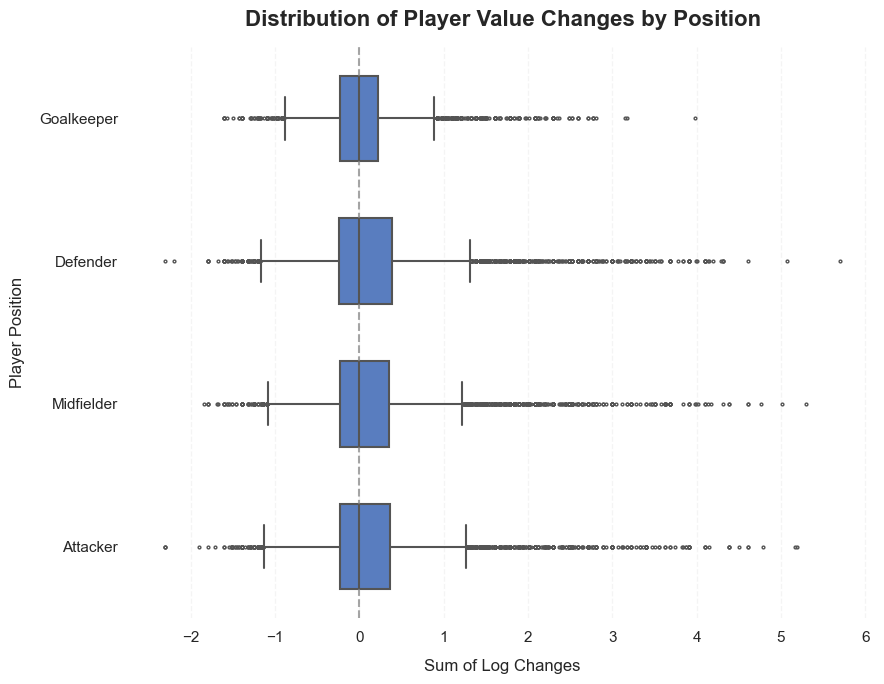

In [27]:
plt.figure(figsize=(9, 7))

ax = sns.boxplot(
    data=curbles_df,
    y='general_position',
    x='sum_log_changes',
    width=0.6,
    linewidth=1.5,
    fliersize=2,
)

plt.title("Distribution of Player Value Changes by Position", fontsize=16, pad=15, fontweight='bold')
plt.xlabel("Sum of Log Changes", fontsize=12, labelpad=10)
plt.ylabel("Player Position", fontsize=12, labelpad=10)
plt.axvline(0, color='gray', linestyle='--', alpha=0.7)

plt.grid(True, axis='x', linestyle='--', alpha=0.2)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

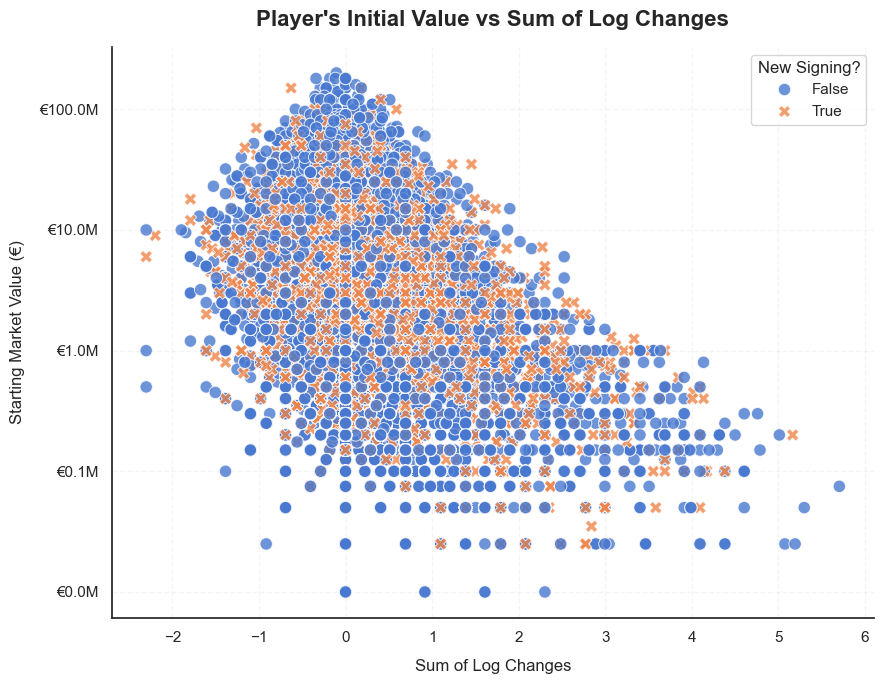

In [28]:
plt.figure(figsize=(9, 7))
ax = sns.scatterplot(
    data=curbles_df,
    y='starting_mv',
    x='sum_log_changes',
    hue='in_new_club',
    style='in_new_club',
    s=80,
    alpha=0.8,
    edgecolor='w',
    linewidth=0.7
)

# Add enhancements
plt.title("Player's Initial Value vs Sum of Log Changes", fontsize=16, pad=15, fontweight='bold')
plt.xlabel("Sum of Log Changes", fontsize=12, labelpad=10)
plt.ylabel("Starting Market Value (€)", fontsize=12, labelpad=10)
plt.yscale('log')

# Format y-axis as euros
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"€{x/1e6:.1f}M"))
plt.legend(title='New Signing?')

# Add grid and layout
plt.grid(True, linestyle='--', alpha=0.2)
sns.despine()
plt.tight_layout()
plt.show()

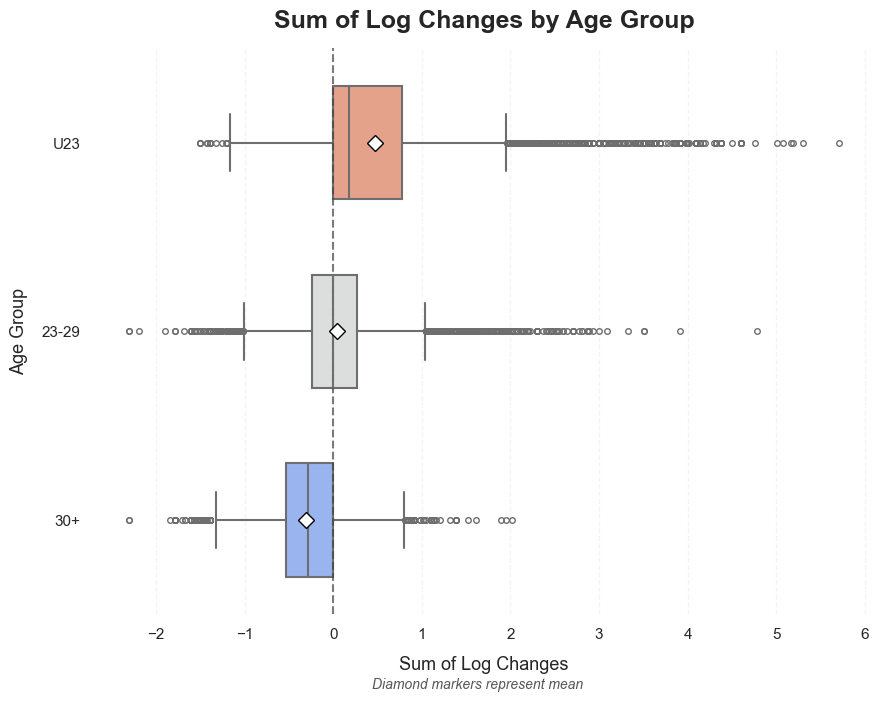

In [29]:
if 'age_group' not in curbles_df.columns:
    age_bins = [0, 22, 29, np.inf]
    age_labels = ['U23', '23-29', '30+']
    curbles_df['age_group'] = pd.cut(
        curbles_df['age_when_assessed'], bins=age_bins, labels=age_labels
    )

plt.figure(figsize=(9, 7))
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.4})

ax = sns.boxplot(
    data=curbles_df,
    y='age_group',
    x='sum_log_changes',
    hue='age_group',
    palette="coolwarm_r",
    width=0.6,
    linewidth=1.5,
    fliersize=4,
    showmeans=True,  # Show mean markers
    meanprops={"marker":"D", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"8"}
)

plt.axvline(0, color='#444444', linestyle='--', alpha=0.7, linewidth=1.5)
plt.title('Sum of Log Changes by Age Group', fontsize=18, pad=15, fontweight='bold')
plt.xlabel('Sum of Log Changes', fontsize=13, labelpad=10)
plt.ylabel('Age Group', fontsize=13, labelpad=10)

plt.figtext(0.54, 0.005, "Diamond markers represent mean",
            ha='center', fontsize=10, fontstyle='italic', color='#555555')
plt.grid(True, axis='x', linestyle='--', alpha=0.2)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

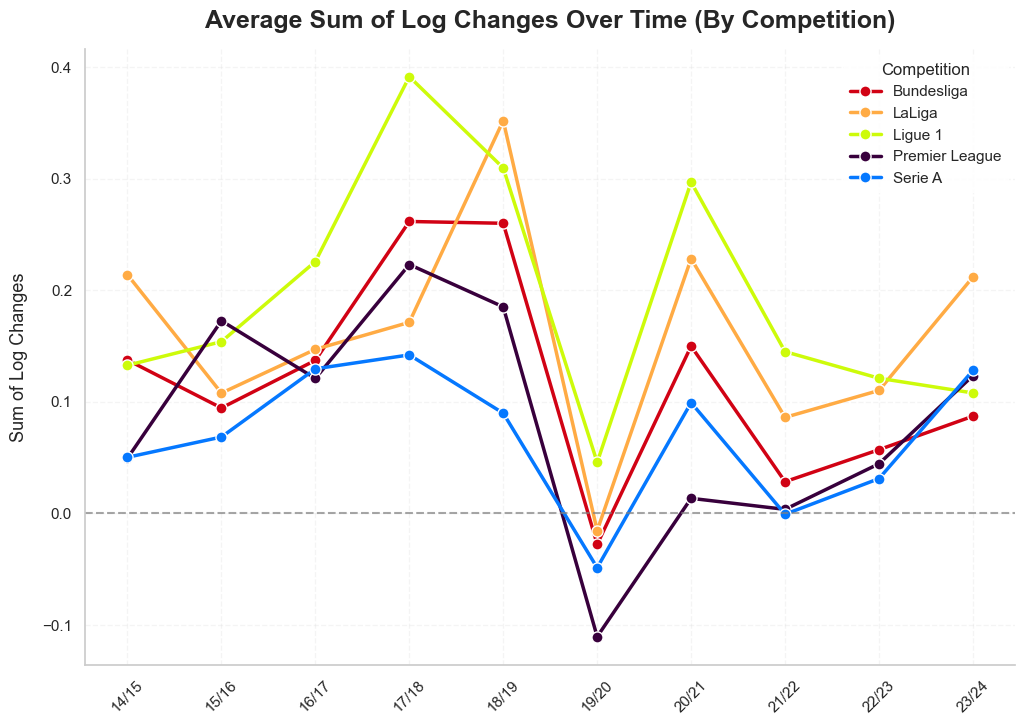

In [30]:
plt.figure(figsize=(12, 8))

ax = sns.lineplot(
    data=curbles_df,
    x='season',
    y='sum_log_changes',
    hue='competition_name',
    palette=competition_colors,
    errorbar=None,
    linewidth=2.5,
    marker='o',
    markersize=8,
    markeredgecolor='white',
    markeredgewidth=1
)

plt.axhline(0, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
plt.title('Average Sum of Log Changes Over Time (By Competition)', fontsize=18, pad=15, fontweight='bold')
plt.xlabel('')
plt.ylabel('Sum of Log Changes', fontsize=13, labelpad=10)

plt.xticks(rotation=45, ha='center')
plt.legend(
    title='Competition',
    frameon=True,
    framealpha=0.9,
    edgecolor='white',
    loc='best'
)

plt.grid(True, alpha=0.2)
sns.despine()
plt.show()

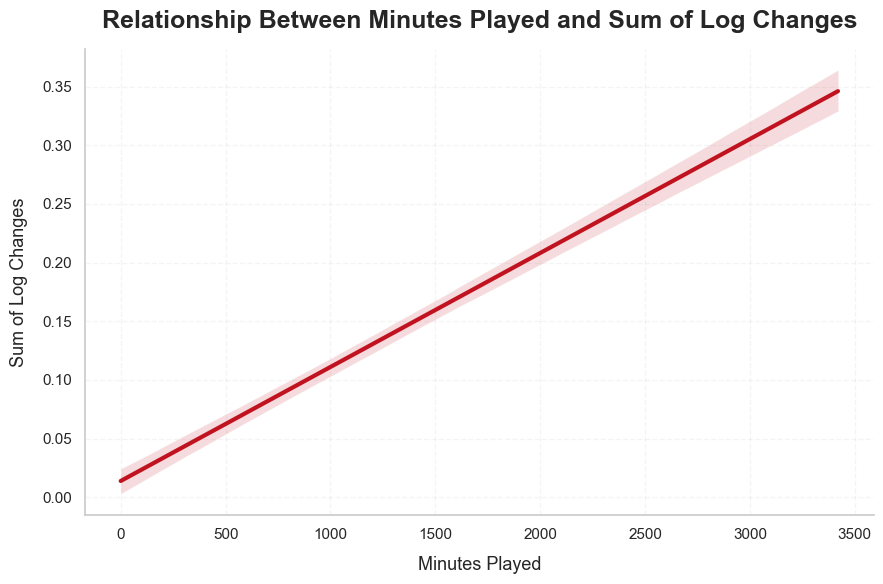

In [31]:
plt.figure(figsize=(9, 6))

ax = sns.regplot(
    data=curbles_df,
    y='sum_log_changes',
    x='minutes_played',
    line_kws={'color': '#c1121f', 'linewidth': 3},
    ci=95,
    scatter=False,
    truncate=True
)

plt.title('Relationship Between Minutes Played and Sum of Log Changes', fontsize=18, pad=15, fontweight='bold')
plt.xlabel('Minutes Played', fontsize=13, labelpad=10)
plt.ylabel('Sum of Log Changes', fontsize=13, labelpad=10)

plt.grid(True, alpha=0.2)
sns.despine()
plt.tight_layout()
plt.show()

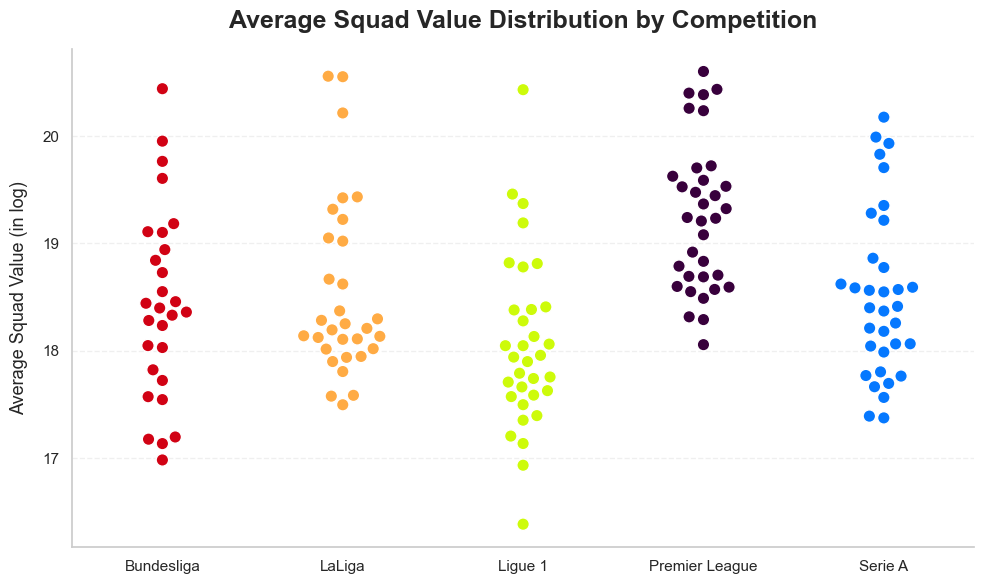

In [32]:
temp_viz = curbles_df.groupby(['competition_name', 'club_id'], observed=True).agg(
    num_seasons=('season', 'nunique'),
    total_player_values=('starting_mv', 'sum')
).reset_index()

temp_viz['average_squad_value'] = temp_viz['total_player_values'] / temp_viz['num_seasons']
temp_viz['log_average_squad_value'] = np.log(temp_viz['average_squad_value'])


plt.figure(figsize=(10, 6))

ax = sns.swarmplot(
    data=temp_viz,
    x='competition_name',
    y='log_average_squad_value',
    hue='competition_name',
    palette=competition_colors,
    size=9,
    alpha=1,
    edgecolor='w',
    linewidth=1
)

plt.title('Average Squad Value Distribution by Competition', fontsize=18, pad=15, fontweight='bold')
plt.xlabel('', fontsize=13, labelpad=10)
plt.ylabel('Average Squad Value (in log)', fontsize=13, labelpad=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

if 'historic_team_value' not in curbles_df:
    curbles_df = curbles_df.merge(
        temp_viz[['club_id', 'log_average_squad_value']],
        on=['club_id'],
        how='left'
    )
    curbles_df.rename(columns={'log_average_squad_value': 'historic_team_value'},
                      inplace=True)

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


X = curbles_df[['season', 'starting_mv', 'in_new_club', 'team_newly_promoted', 'general_position', 'age_group', 'historic_team_value', 'competition_id']]
y = curbles_df['sum_log_changes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['historic_team_value', 'starting_mv']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['season', 'age_group', 'general_position', 'competition_id']),
        ('bool', 'passthrough', ['in_new_club', 'team_newly_promoted'])
    ],
    remainder='drop'
)

display(X_train.head())

season  starting_mv  in_new_club team_newly_promoted general_position  \
1930   14/15      5000000         True               False         Attacker   
8493   16/17      7000000         True                True       Midfielder   
14220  18/19     10000000         True               False         Defender   
10958  17/18      1800000        False               False         Defender   
25609  22/23      3000000        False               False         Attacker   

      age_group  historic_team_value competition_id  
1930      23-29            18.384244            FR1  
8493      23-29            18.110656            ES1  
14220       U23             19.19087            FR1  
10958     23-29            17.390895            IT1  
25609       30+             18.28191             L1

In [34]:
"""
Usually keep commented b/c long run-time
"""
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=8),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=8)
}

results = []

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=8)
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Cross-validation scores
    mae_scores = -cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2')

    results.append({
        'model': name,
        'mean_MAE': np.mean(mae_scores),
        'std_MAE': np.std(mae_scores),
        'mean_R2': np.mean(r2_scores),
        'std_R2': np.std(r2_scores)
    })

results_df = pd.DataFrame(results)
print(results_df)

'\nUsually keep commented b/c long run-time\n'

In [35]:
"""
Usually keep commented b/c long run-time
"""
param_grid = {
    'GradientBoosting': {
        'regressor__n_estimators': [100, 200, 500],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [5, 7, 9],
        'regressor__subsample': [0.8, 0.9, 1.0]
    },
    'RandomForest': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    }
}

# Gradient Boosting hyperparameter tuning
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

search_gb = RandomizedSearchCV(
    pipeline_gb,
    param_distributions=param_grid['GradientBoosting'],
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=8
)
search_gb.fit(X_train, y_train)
print("Gradient Boosting:", search_gb.best_params_, search_gb.best_score_)


# Random Forest hyperparameter tuning
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid['RandomForest'],
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=8
)
search_rf.fit(X_train, y_train)
print("Random Forest:", search_rf.best_params_, search_rf.best_score_)

'\nUsually keep commented b/c long run-time\n'

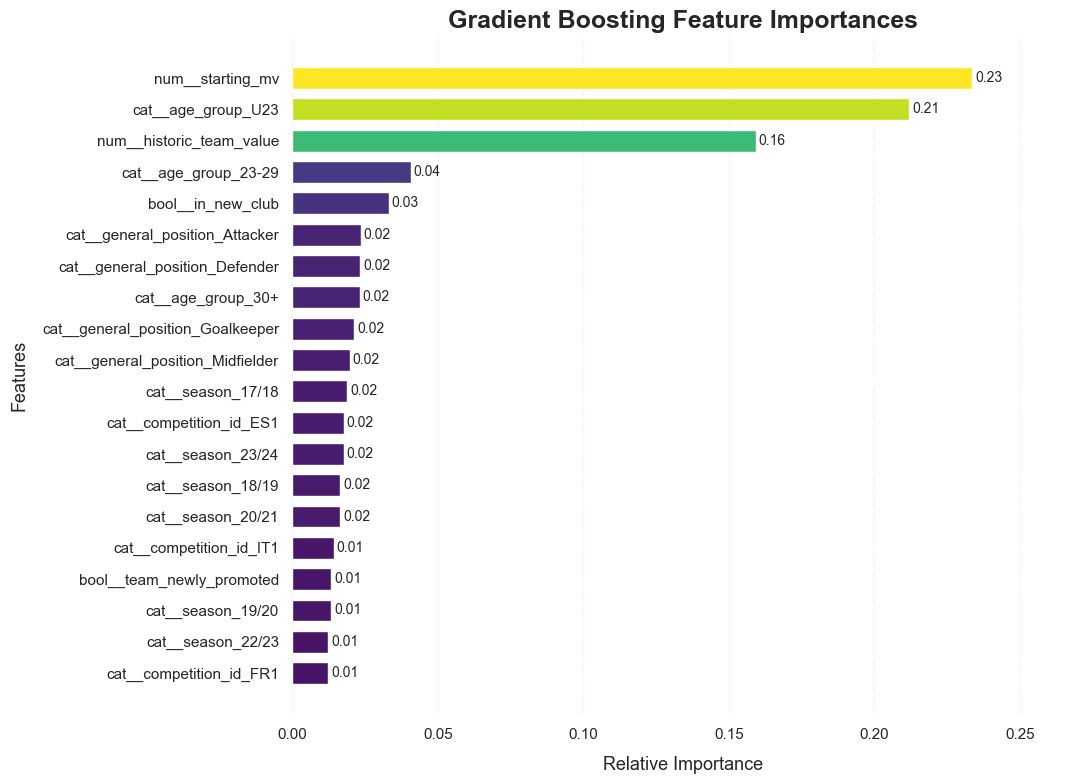

In [36]:
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=500,
                                            subsample=1.0,
                                            max_depth=7,
                                            learning_rate=0.1,
                                            random_state=8))
])
gb_pipeline.fit(X_train, y_train)

# Get feature importances and names
feature_names = preprocessor.get_feature_names_out()
importances = gb_pipeline.named_steps['regressor'].feature_importances_


plt.figure(figsize=(11, 8))

sorted_idx = importances.argsort()[::-1]
top_features = np.array(feature_names)[sorted_idx][:20]  # Showing top 20 features
top_importances = importances[sorted_idx][:20]


colors = plt.cm.viridis(top_importances / max(top_importances))
bars = plt.barh(top_features, top_importances, color=colors, edgecolor='white', height=0.7)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001,
             bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             ha='left',
             va='center',
             fontsize=10)

plt.title('Gradient Boosting Feature Importances', fontsize=18, fontweight='bold')
plt.xlabel('Relative Importance', fontsize=13, labelpad=10)
plt.ylabel('Features', fontsize=13, labelpad=10)

plt.xlim(0, max(top_importances) * 1.15)
plt.grid(True, axis='x', linestyle='--', alpha=0.2); plt.grid(False, axis='y')
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.gca().invert_yaxis()
plt.show()

In [37]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=200,
        subsample=.9,
        max_depth=7,
        learning_rate=0.05,
        random_state=8
    ))
])

# Train model
model.fit(X_train, y_train, regressor__sample_weight=X_train['starting_mv'])

# Evaluate on test set
y_pred = model.predict(X_test)

print("Model Performance:")
print(f"- Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"- Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"- Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.4f}")
print(f"- R²: {r2_score(y_test, y_pred):.4f}")

Model Performance:
- Test MAE: 0.4247
- Test RMSE: 0.5979
- Train MAE: 0.3785
- R²: 0.2749


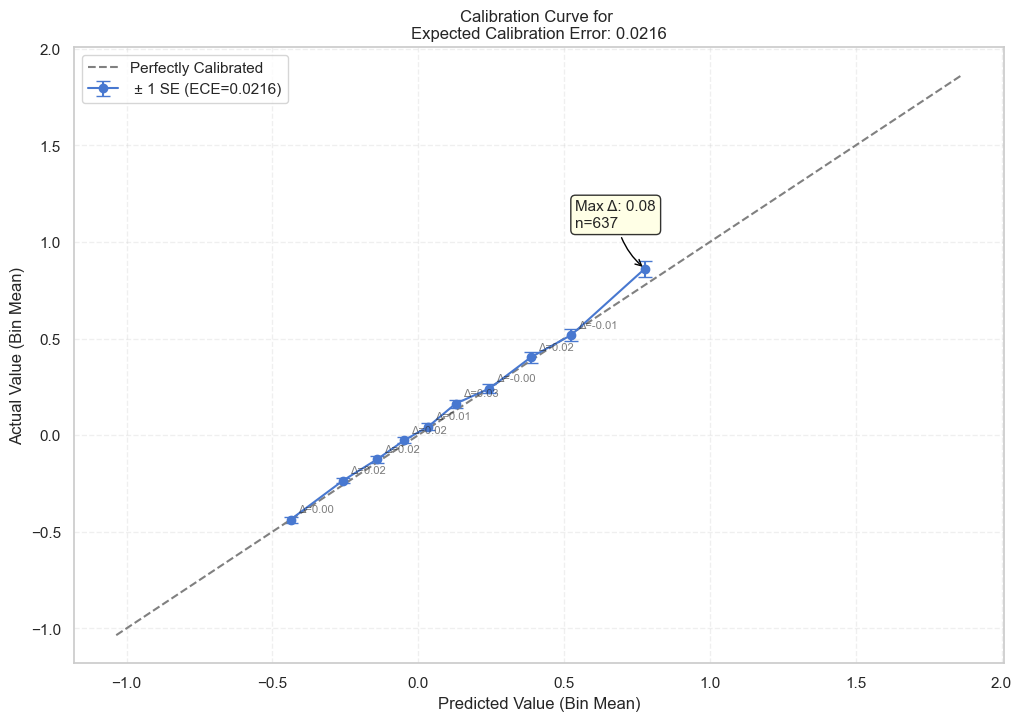

np.float64(0.021611399975548923)

In [38]:
def plot_calibration_curve(y_true, y_pred, n_bins=10, model_name=""):
    """
    Plots a calibration curve with error bars and annotations for deviation from perfect calibration.
    Also calculates Expected Calibration Error (ECE).

    Parameters:
    y_true (array): True target values.
    y_pred (array): Predicted target values.
    n_bins (int): Number of bins to use for grouping predictions.
    model_name (str): Name of the model for plot title.
    """
    percentiles = np.linspace(0, 100, n_bins + 1)
    bin_edges = np.percentile(y_pred, percentiles)
    bin_edges[-1] += 1e-8
    bin_indices = np.digitize(y_pred, bin_edges, right=True)

    bin_means_pred = []
    bin_means_true = []
    bin_std_true = []   # Standard deviation of true values in the bin
    bin_counts = []     # Number of samples in the bin
    bin_se_true = []    # Standard error of the mean for the bin
    deviations = []     # Deviation from perfect calibration (actual - predicted)

    for bin_idx in range(1, n_bins + 1):
        mask = bin_indices == bin_idx
        if np.any(mask):
            mean_pred = np.mean(y_pred[mask])
            mean_true = np.mean(y_true[mask])
            bin_means_pred.append(mean_pred)
            bin_means_true.append(mean_true)
            bin_std_true.append(np.std(y_true[mask]))
            count = np.sum(mask)
            bin_counts.append(count)

            bin_se_true.append(np.std(y_true[mask]) / np.sqrt(count))

            deviation = mean_true - mean_pred
            deviations.append(deviation)

    bin_means_pred = np.array(bin_means_pred)
    bin_means_true = np.array(bin_means_true)
    bin_se_true = np.array(bin_se_true)
    deviations = np.array(deviations)
    bin_counts = np.array(bin_counts)

    # Calculate Expected Calibration Error (weighted average of absolute deviations)
    ece = np.average(np.abs(deviations), weights=bin_counts)

    plt.figure(figsize=(12, 8))
    plt.errorbar(bin_means_pred, bin_means_true, yerr=bin_se_true, fmt='o-',
                 label=f'{model_name} ± 1 SE (ECE={ece:.4f})', capsize=5)
    plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], '--',
             color='gray', label='Perfectly Calibrated')

    # Find the point with the maximum absolute deviation
    max_dev_idx = np.argmax(np.abs(deviations))
    max_dev_point = (bin_means_pred[max_dev_idx], bin_means_true[max_dev_idx])
    max_dev_value = deviations[max_dev_idx]
    max_dev_count = bin_counts[max_dev_idx]

    # Add annotation for the point with maximum deviation
    plt.annotate(f'Max Δ: {max_dev_value:.2f}\nn={max_dev_count}',
                 xy=max_dev_point,
                 xytext=(-50, 30), textcoords='offset points',
                 fontsize=11,
                 bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="black", alpha=0.8),
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color="black"))

    # Optionally, add smaller annotations for other points (just the deviation, no text box)
    for i in range(len(bin_means_pred)):
        if i != max_dev_idx:  # Skip the point we already annotated
            plt.annotate(f'Δ={deviations[i]:.2f}', 
                         xy=(bin_means_pred[i], bin_means_true[i]),
                         xytext=(5, 5), textcoords='offset points',
                         fontsize=8, alpha=0.6)

    plt.xlabel('Predicted Value (Bin Mean)')
    plt.ylabel('Actual Value (Bin Mean)')
    plt.title(f'Calibration Curve for {model_name}\nExpected Calibration Error: {ece:.4f}')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()

    return ece

plot_calibration_curve(y_test, y_pred, n_bins=10)

In [40]:
curbles_df['expected_sum_log_changes'] = model.predict(curbles_df[['season', 'minutes_played', 'starting_mv', 'in_new_club', 'team_newly_promoted', 'general_position', 'age_group', 'historic_team_value', 'competition_id']])
curbles_df['performance_residual'] = curbles_df['sum_log_changes'] - curbles_df['expected_sum_log_changes']


bins = pd.qcut(curbles_df['starting_mv'], q=10, retbins=True, duplicates='drop')[1]
labels = [f"{int(bins[i]):,}-{int(bins[i+1]):,}" for i in range(len(bins)-1)]
curbles_df['player_value_bin'] = pd.qcut(
    curbles_df['starting_mv'],
    q=10,
    labels=labels,
    duplicates='drop'
)

bin_stats = (
    curbles_df
    .groupby('player_value_bin', observed=True)['performance_residual']
    .agg(['mean', 'std'])
    .rename(columns={'mean': 'bin_mean', 'std': 'bin_std'})
)

curbles_df = curbles_df.merge(
    bin_stats,
    left_on='player_value_bin',
    right_index=True
)


# Standardize residuals
curbles_df['standardized_performance_residual'] = (
    (curbles_df['performance_residual'] - curbles_df['bin_mean']) / curbles_df['bin_std']
)

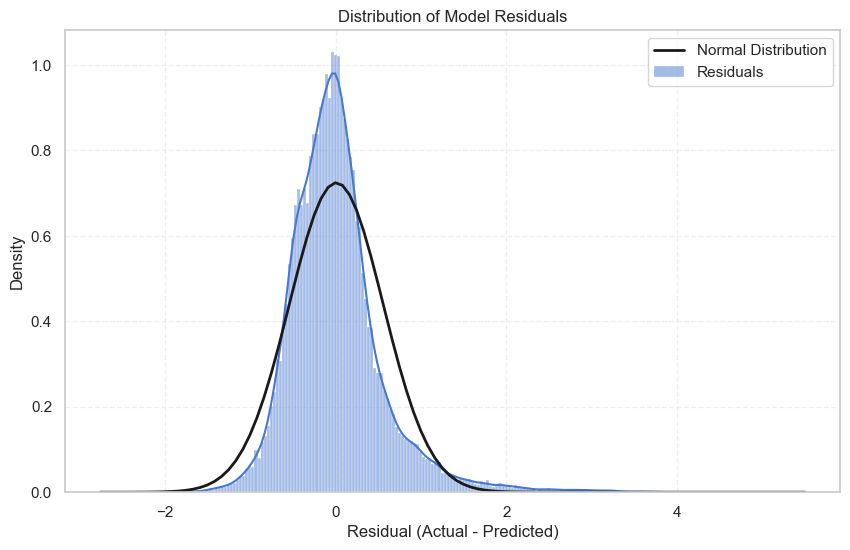

Residual Mean: 0.006503 (Should be very close to 0)
Residual Skewness: 1.5115
Residual Kurtosis: 5.7406


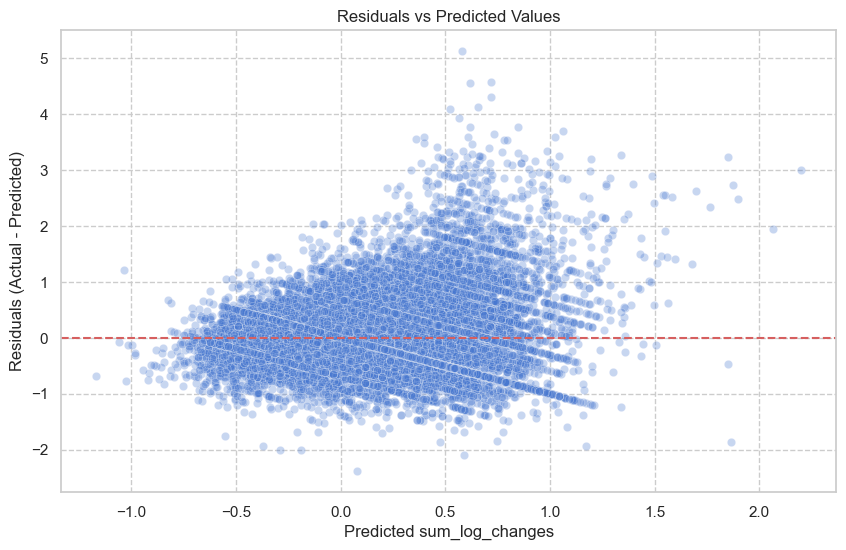

In [41]:
plt.figure(figsize=(10, 6))

sns.histplot(curbles_df['performance_residual'], stat='density', kde=True, alpha=0.5, label='Residuals')
mu, std = np.mean(curbles_df['performance_residual']), np.std(curbles_df['performance_residual'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

plt.title('Distribution of Model Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Residual Mean: {mu:.6f} (Should be very close to 0)")
print(f"Residual Skewness: {stats.skew(curbles_df['performance_residual']):.4f}")
print(f"Residual Kurtosis: {stats.kurtosis(curbles_df['performance_residual']):.4f}")


plt.figure(figsize=(10, 6))

sns.scatterplot(x=curbles_df['expected_sum_log_changes'], y=curbles_df['performance_residual'], alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted sum_log_changes')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

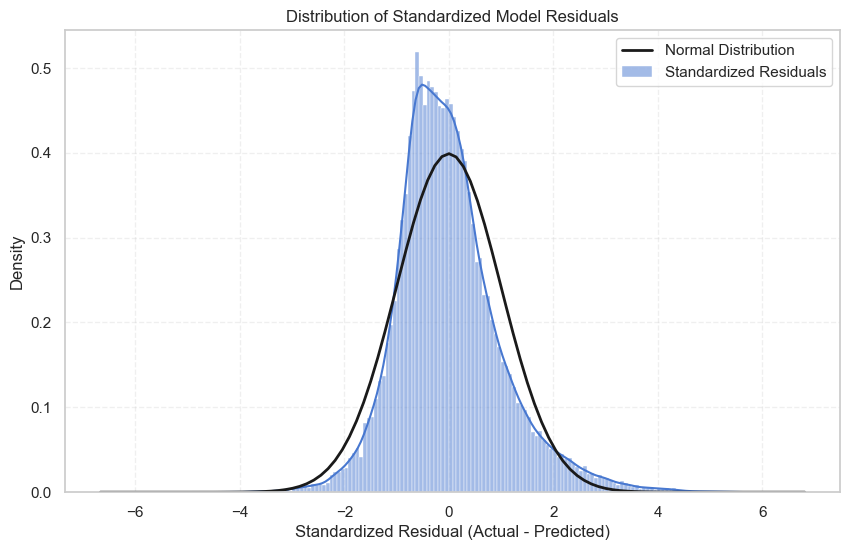

Residual Mean: 0.000000 (Should be very close to 0)
Residual Skewness: 0.7589
Residual Kurtosis: 1.9415


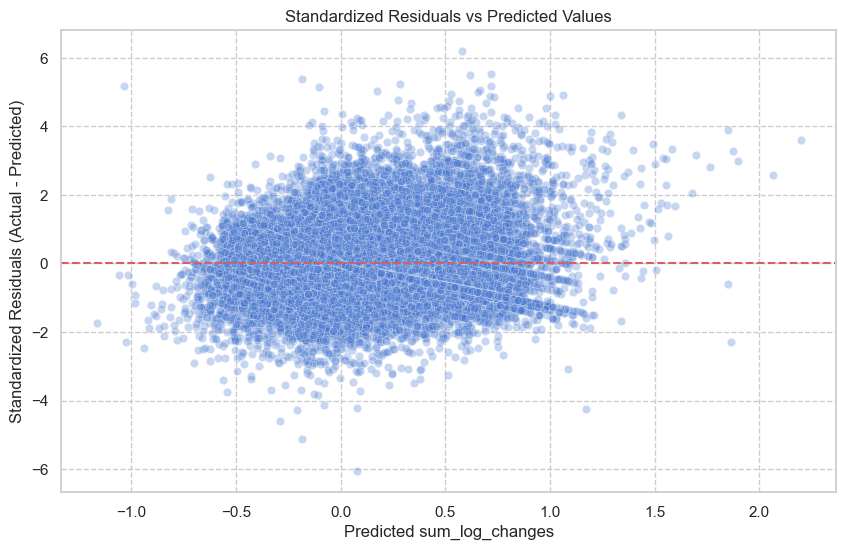

In [42]:
plt.figure(figsize=(10, 6))

sns.histplot(curbles_df['standardized_performance_residual'], stat='density', kde=True, alpha=0.5, label='Standardized Residuals')
mu, std = np.mean(curbles_df['standardized_performance_residual']), np.std(curbles_df['standardized_performance_residual'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

plt.title('Distribution of Standardized Model Residuals')
plt.xlabel('Standardized Residual (Actual - Predicted)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Residual Mean: {mu:.6f} (Should be very close to 0)")
print(f"Residual Skewness: {stats.skew(curbles_df['standardized_performance_residual']):.4f}")
print(f"Residual Kurtosis: {stats.kurtosis(curbles_df['standardized_performance_residual']):.4f}")


plt.figure(figsize=(10, 6))

sns.scatterplot(x=curbles_df['expected_sum_log_changes'], y=curbles_df['standardized_performance_residual'], alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Standardized Residuals vs Predicted Values')
plt.xlabel('Predicted sum_log_changes')
plt.ylabel('Standardized Residuals (Actual - Predicted)')
plt.show()

In [43]:
display(curbles_df.sort_values(['standardized_performance_residual'], ascending=False).head(n=20).style.format({"starting_mv": "{:,.0f}", "sum_total_changes": "{:,.0f}"}))

#### _EDA on new score metric_

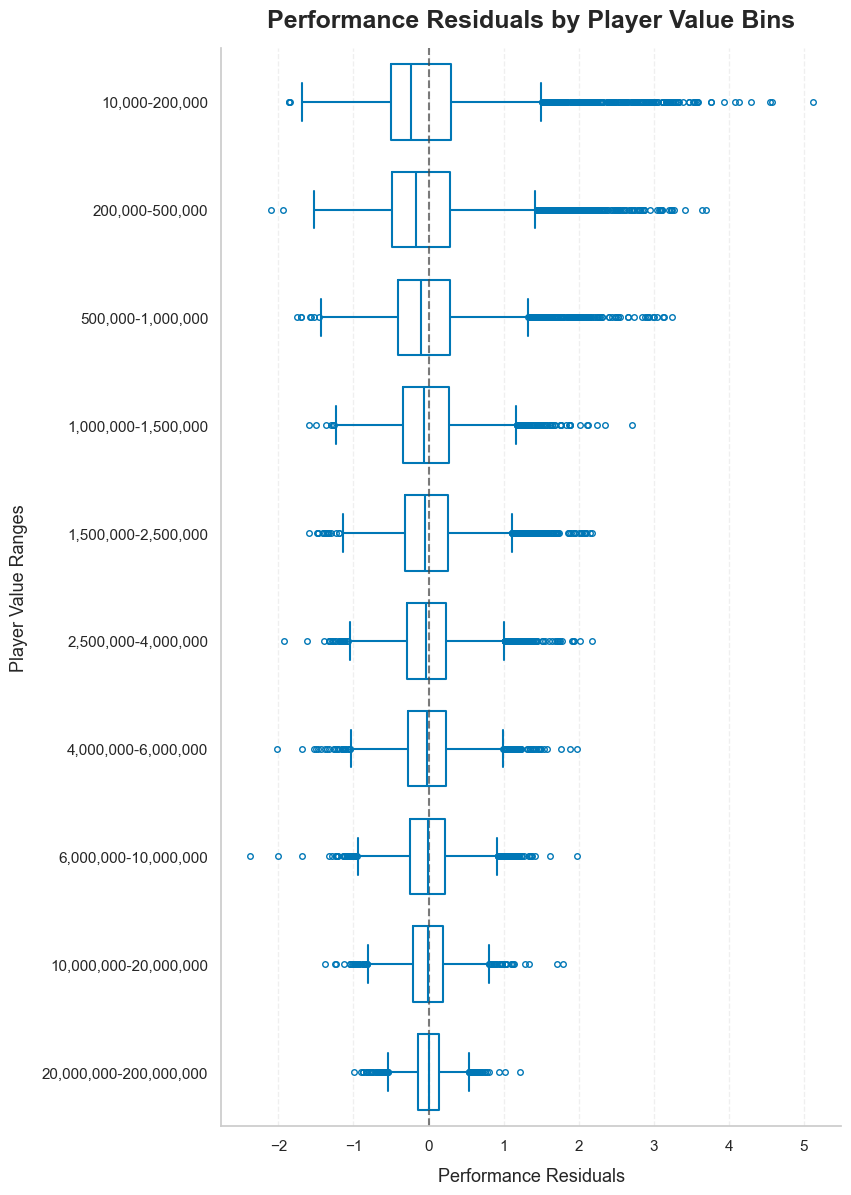

In [44]:
plt.figure(figsize=(8, 14))

# Create the boxplot with enhancements
ax = sns.boxplot(
    data=curbles_df,
    x='performance_residual',
    y='player_value_bin',
    width=0.7,
    fill=False,
    color='#0077b6',
    linewidth=1.5,
    fliersize=4,
)


plt.axvline(0, color='#444444', linestyle='--', alpha=0.7, linewidth=1.5)
plt.title('Performance Residuals by Player Value Bins', fontsize=18, pad=15, fontweight='bold')
plt.xlabel('Performance Residuals', fontsize=13, labelpad=10)
plt.ylabel('Player Value Ranges', fontsize=13, labelpad=10)
plt.grid(True, axis='x', alpha=0.3)
sns.despine()
plt.show()

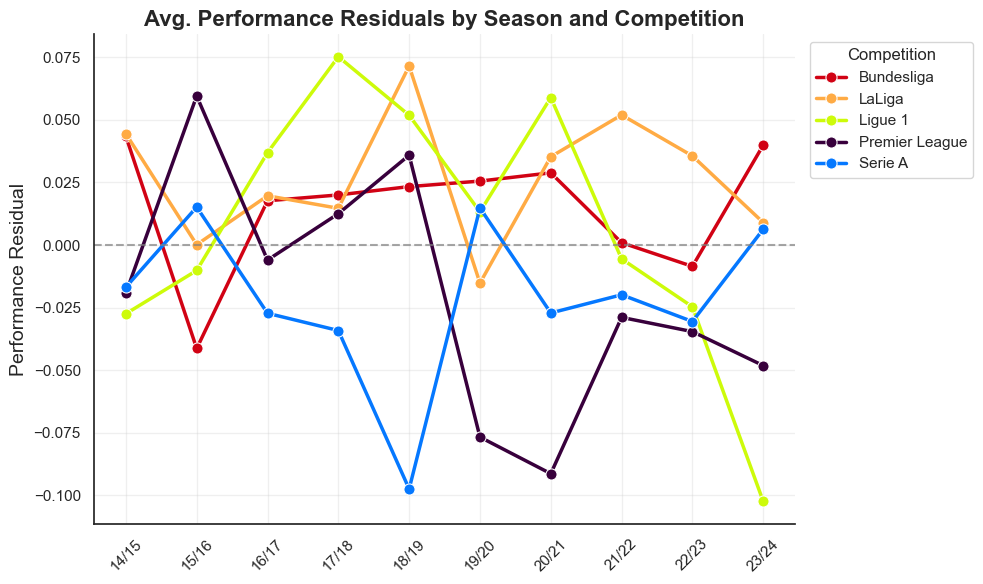

In [45]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="white", palette="muted")


line_plot = sns.lineplot(
    data=curbles_df,
    x='season',
    y='standardized_performance_residual',
    hue='competition_name',
    palette=competition_colors,
    errorbar=None,
    linewidth=2.5,
    marker='o',
    markersize=8,
    estimator='mean'
)

plt.title('Avg. Performance Residuals by Season and Competition', fontsize=16, weight='bold')
plt.xlabel('', fontsize=14)
plt.ylabel('Performance Residual', fontsize=14)
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.legend(title='Competition', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=True)

# Rotate season labels for readability
plt.xticks(rotation=45, ha='center')

# Add gridlines
plt.grid(alpha=0.3)

sns.despine()
plt.tight_layout()
plt.show()

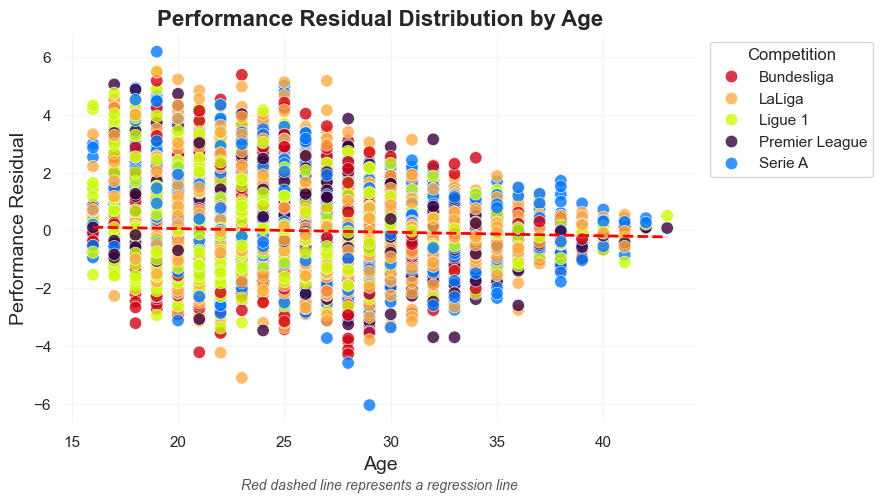

In [46]:
plt.figure(figsize=(9, 5))

scatter_age = sns.scatterplot(
    data=curbles_df,
    x='age_when_assessed',
    y='standardized_performance_residual',
    hue='competition_name',
    palette=competition_colors,
    alpha=0.8,
    s=80,
    edgecolor='w',
    linewidth=0.5
)

sns.regplot(
    data=curbles_df,
    x='age_when_assessed',
    y='standardized_performance_residual',
    scatter=False,
    color='red',
    line_kws={'lw': 2, 'ls': '--'}
)

plt.title('Performance Residual Distribution by Age', fontsize=16, weight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Performance Residual', fontsize=14)
plt.figtext(0.43, 0.005, "Red dashed line represents a regression line", 
            ha='center', fontsize=10, fontstyle='italic', color='#555555')
plt.legend(title='Competition', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.grid(alpha=0.2)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

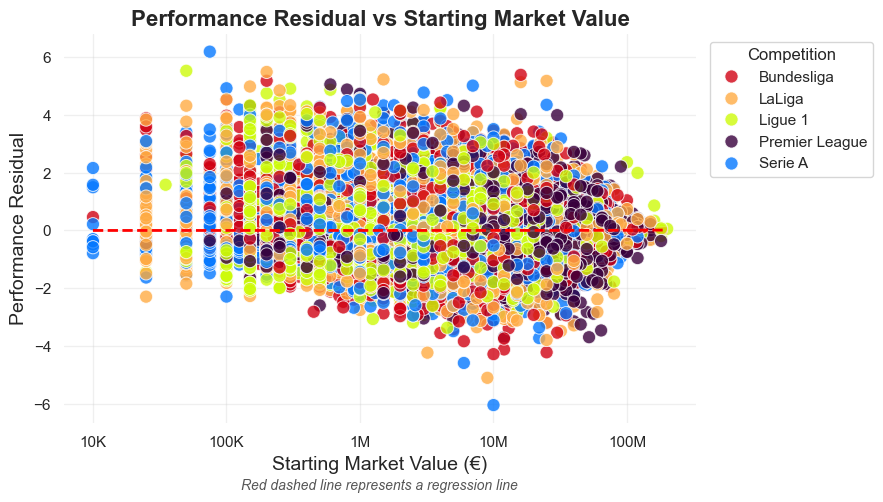

In [47]:
plt.figure(figsize=(9, 5))


scatter_mv = sns.scatterplot(
    data=curbles_df,
    x='starting_mv',
    y='standardized_performance_residual',
    hue='competition_name',
    palette=competition_colors,
    alpha=0.8,
    s=90,
    edgecolor='w',
    linewidth=0.7
)

sns.regplot(
    data=curbles_df,
    x='starting_mv',
    y='standardized_performance_residual',
    scatter=False,
    color='red',
    line_kws={'lw': 2, 'ls': '--'}
)

plt.xscale('log')


tick_values = [10000, 100000, 1000000, 10000000, 100000000]
tick_labels = ['10K', '100K', '1M', '10M', '100M']
plt.xticks(ticks=tick_values, labels=tick_labels)

plt.grid(alpha=0.3, axis='both')
plt.title('Performance Residual vs Starting Market Value', fontsize=16, weight='bold')
plt.xlabel('Starting Market Value (€)', fontsize=14)
plt.ylabel('Performance Residual', fontsize=14)

plt.figtext(0.43, 0.005, "Red dashed line represents a regression line", 
            ha='center', fontsize=10, fontstyle='italic', color='#555555')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Competition', 
           bbox_to_anchor=(1.01, 1), loc='upper left')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

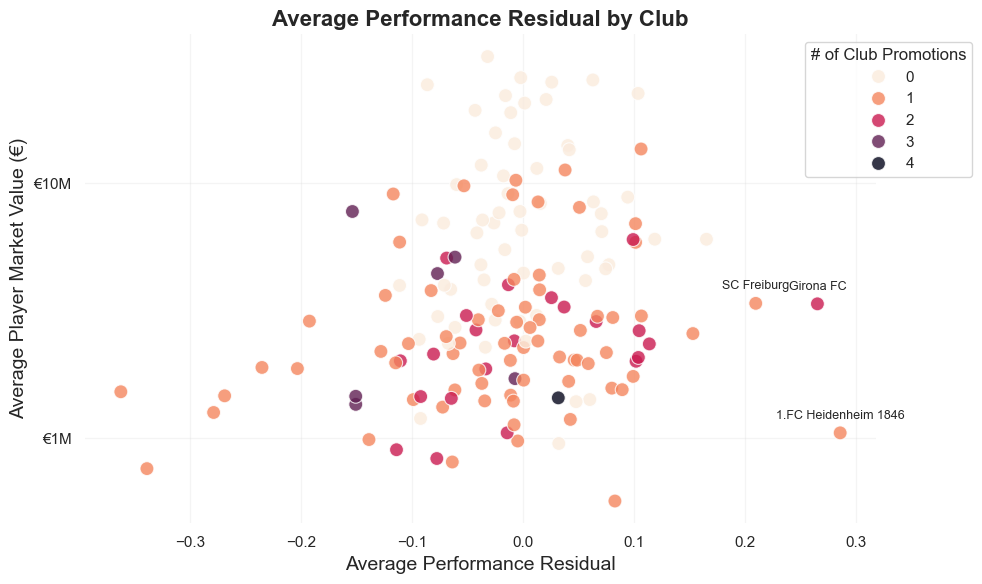

In [49]:
club_stats = curbles_df.groupby('club_id').agg(
    avg_starting_mv=('starting_mv', 'mean'),
    avg_log_score=('standardized_performance_residual', 'mean'),
    competition_name=('competition_name', 'first'),  # All entries same for club
    club_name=('club_name', 'first')
).reset_index()
team_promotion_count = expanded_competition_clubs.groupby('club_id').agg(
    num_promotions=('is_newly_promoted', 'sum')
).reset_index()
club_stats = club_stats.merge(team_promotion_count, on='club_id')

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=club_stats,
    x='avg_log_score',
    y='avg_starting_mv',
    hue='num_promotions',
    palette='rocket_r',
    s=100,
    alpha=0.8
)

plt.title('Average Performance Residual by Club', fontsize=16, weight='bold')
plt.xlabel('Average Performance Residual', fontsize=14)
plt.ylabel('Average Player Market Value (€)', fontsize=14)
plt.legend(title='# of Club Promotions', bbox_to_anchor=(.9, 1), loc='upper left')

# Adding club labels for outliers
top_clubs = club_stats.nlargest(3, 'avg_log_score')
for _, row in top_clubs.iterrows():
    plt.annotate(row['club_name'],
                 (row['avg_log_score'], row['avg_starting_mv']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=9)

plt.yscale('log')
tick_values = [1000000, 10000000]
tick_labels = ['€1M', '€10M']
plt.yticks(ticks=tick_values, labels=tick_labels)
# ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"€{x/1e6:.1f}M"))

plt.grid(alpha=0.2)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

#### Aggregated Jersey Numbers Analysis

In [50]:
'''
Dropping Ligue 1 observations because of the transfermarkt issue (shows multiple jersey numbers wore)
'''
curbles_filtered_df = curbles_df.drop(curbles_df[curbles_df['competition_name'] == 'Ligue 1'].index)
curbles_filtered_df.competition_name = curbles_filtered_df.competition_name.cat.remove_unused_categories()
print(curbles_filtered_df.competition_name.cat.categories)

Index(['Bundesliga', 'LaLiga', 'Premier League', 'Serie A'], dtype='object')


In [51]:
jersey_stats = curbles_filtered_df.groupby(by=['competition_name', 'jersey_number'], observed=True).agg(
    avg_performance_score=('standardized_performance_residual', 'mean'),
    observation_count=('standardized_performance_residual', 'count')
).reset_index()

custom_bins = [0, 11, 25, np.inf]
bin_labels = ['1-11', '12-25', '26+']

jersey_stats['jersey_num_bins'] = pd.cut(
    jersey_stats['jersey_number'], bins=custom_bins, labels=bin_labels
)

display(jersey_stats[jersey_stats['observation_count'] >= 40].sort_values('avg_performance_score', ascending=True).head(25))

competition_name  jersey_number  avg_performance_score  observation_count  \
92            LaLiga             37               -0.34092                 55   
248          Serie A             40              -0.337275                 61   
145   Premier League             34              -0.278214                 60   
36        Bundesliga             37              -0.254783                100   
149   Premier League             38              -0.238352                 50   
90            LaLiga             35              -0.223151                 63   
304          Serie A             96              -0.213282                 42   
220          Serie A             12              -0.208879                 97   
252          Serie A             44              -0.201593                 71   
27        Bundesliga             28              -0.201376                135   
247          Serie A             39              -0.196632                 47   
305          Serie A             97              -0.186841                 58   
33        Bundesliga             34              -0.184788                109   
263          Serie A             55              -0.176268                 58   
138   Premier League             27              -0.170359                140   
130   Premier League             19              -0.166015                181   
153   Premier League             42              -0.160963                 43   
23        Bundesliga             24              -0.159958                140   
72            LaLiga             17              -0.157648                214   
234          Serie A             26               -0.14152                119   
17        Bundesliga             18              -0.131327                165   
14        Bundesliga             15              -0.127353                129   
88            LaLiga             33              -0.126345                 69   
301          Serie A             93              -0.124167                 45   
133   Premier League             22              -0.121053                175   

    jersey_num_bins  
92              26+  
248             26+  
145             26+  
36              26+  
149             26+  
90              26+  
304             26+  
220           12-25  
252             26+  
27              26+  
247             26+  
305             26+  
33              26+  
263             26+  
138             26+  
130           12-25  
153             26+  
23            12-25  
72            12-25  
234             26+  
17            12-25  
14            12-25  
88              26+  
301             26+  
133           12-25

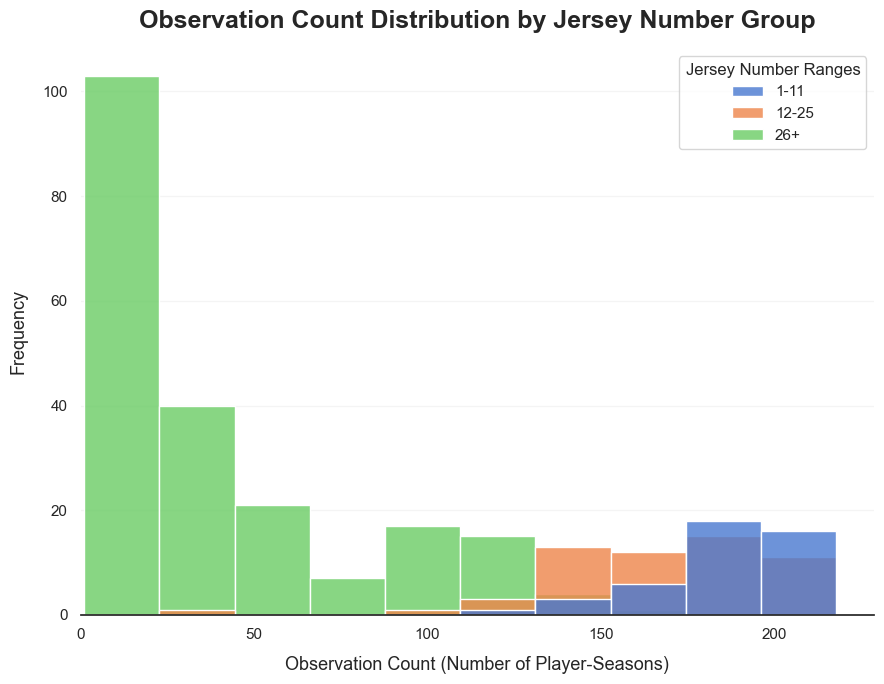

In [52]:
# Set up the figure
plt.figure(figsize=(9, 7))

# Create the histogram with enhancements
ax = sns.histplot(
    data=jersey_stats,
    x='observation_count',
    hue='jersey_num_bins',
    element='bars',
    alpha=0.8,
)

# Add titles and labels
plt.title('Observation Count Distribution by Jersey Number Group', fontsize=18, pad=15, fontweight='bold')
plt.xlabel('Observation Count (Number of Player-Seasons)', fontsize=13, labelpad=10)
plt.ylabel('Frequency', fontsize=13, labelpad=10)
plt.xlim(0)

sns.move_legend(
    ax, "upper right", title='Jersey Number Ranges', frameon=True,
)

# Adjust grid and layout
plt.grid(True, axis='y', alpha=0.2)
sns.despine(left=True)
plt.tight_layout()
plt.show()

In [53]:
jersey_stats_filtered = jersey_stats.drop(jersey_stats[jersey_stats['observation_count'] < 40].index)

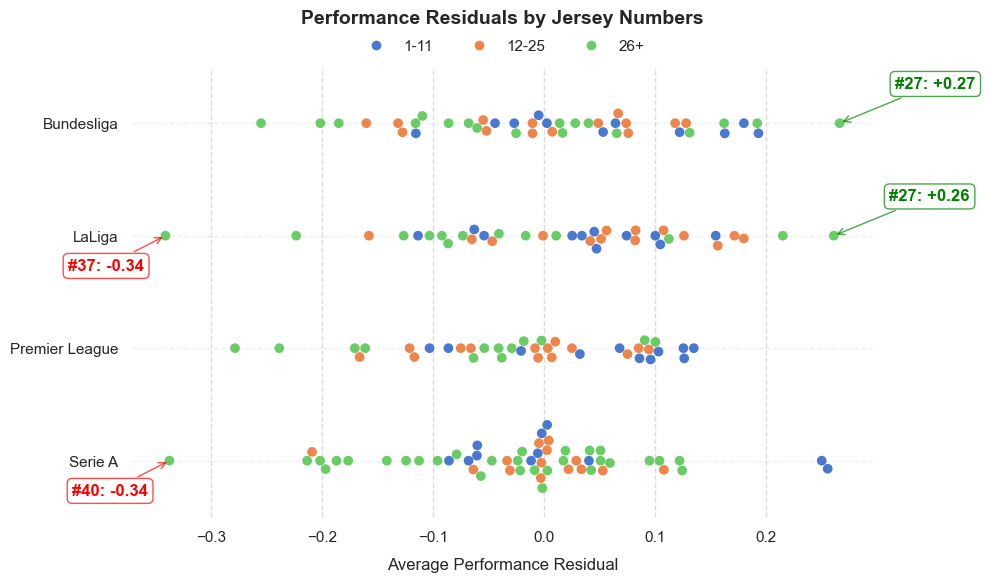

In [54]:
plt.figure(figsize=(10, 6))


ax = sns.swarmplot(
    data=jersey_stats_filtered,
    x="avg_performance_score",
    y="competition_name",
    hue="jersey_num_bins",
    size=7,
)

plt.xlabel("Average Performance Residual", fontsize=12, labelpad=10)
plt.ylabel("")
plt.title("Performance Residuals by Jersey Numbers", fontsize=14, pad=15, weight='bold', y=1.05)

# Find top/bottom performers
sorted_df = jersey_stats_filtered.sort_values('avg_performance_score')
bottom2 = sorted_df.head(2)
top2 = sorted_df.tail(2)

# Highlight bottom performers
for _, row in bottom2.iterrows():
    ax.annotate(
        f"#{row['jersey_number']}: {round(row['avg_performance_score'], 2)}",
        xy=(row['avg_performance_score'], row['competition_name']),
        xytext=(-70, -25),
        textcoords='offset points',
        arrowprops=dict(arrowstyle="->", color='red', alpha=0.7),
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.7),
        color='red',
        fontweight='bold'
    )

# Highlight top performers
for _, row in top2.iterrows():
    ax.annotate(
        f"#{row['jersey_number']}: +{round(row['avg_performance_score'], 2)}",
        xy=(row['avg_performance_score'], row['competition_name']),
        xytext=(40, 25),
        textcoords='offset points',
        arrowprops=dict(arrowstyle="->", color='green', alpha=0.7),
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.7),
        color='green',
        fontweight='bold'
    )

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

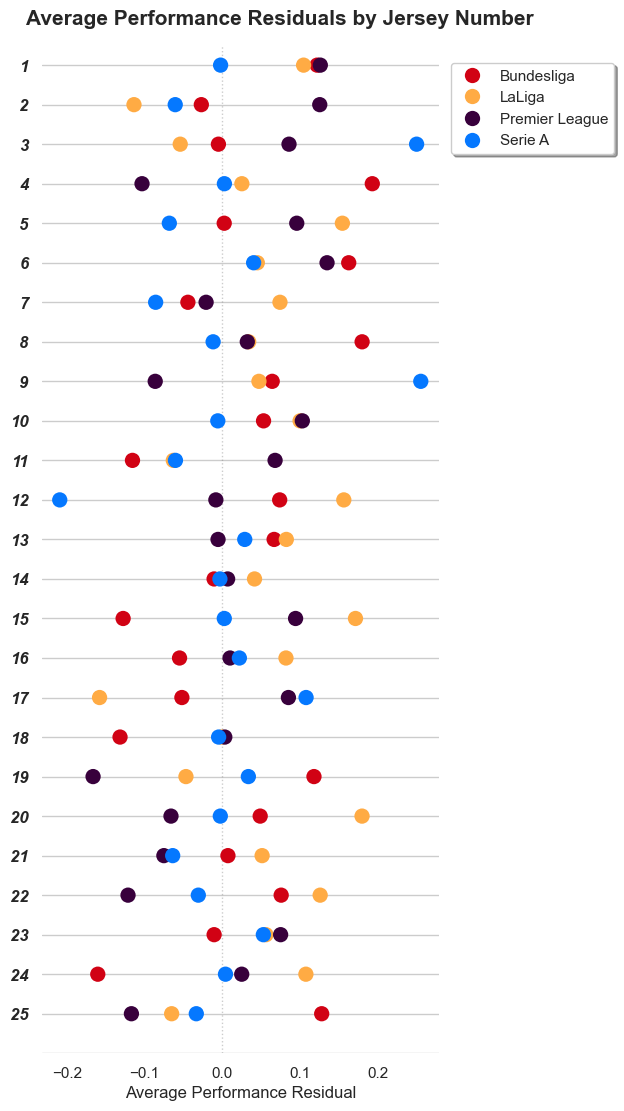

In [55]:
g = sns.PairGrid(jersey_stats[jersey_stats['jersey_num_bins'] != '26+'],
                 x_vars=['avg_performance_score'],
                 y_vars=['jersey_number'],
                 hue='competition_name',
                 palette=competition_colors,
                 height=11,
                 aspect=.45,
                 )

g.map(sns.stripplot,
      size=11,
      orient="h",
      jitter=False,
      linewidth=0,
      edgecolor="w",
      alpha=1)

g.set(xlabel="Average Performance Residual", ylabel="")
g.fig.suptitle("Average Performance Residuals by Jersey Number", fontsize=15, weight='bold', y=1.01)

for ax in g.axes.flat:
    ax.set_yticks(range(0,26))
    ax.set_yticklabels(ax.get_yticklabels(), 
                       fontstyle='italic', 
                       fontweight='bold',
                       fontsize=12)

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

plt.axvline(0, color='gray', linestyle=':', alpha=0.4, linewidth=1)

g.add_legend(title="", label_order=jersey_stats['competition_name'].unique(),
             bbox_to_anchor=(1.02, 0.92), frameon=True, shadow=True)
g.legend.get_frame().set_facecolor('#FFFFFF')
g.legend.get_title().set_fontsize(12)

sns.despine(left=True, bottom=True)
plt.show()

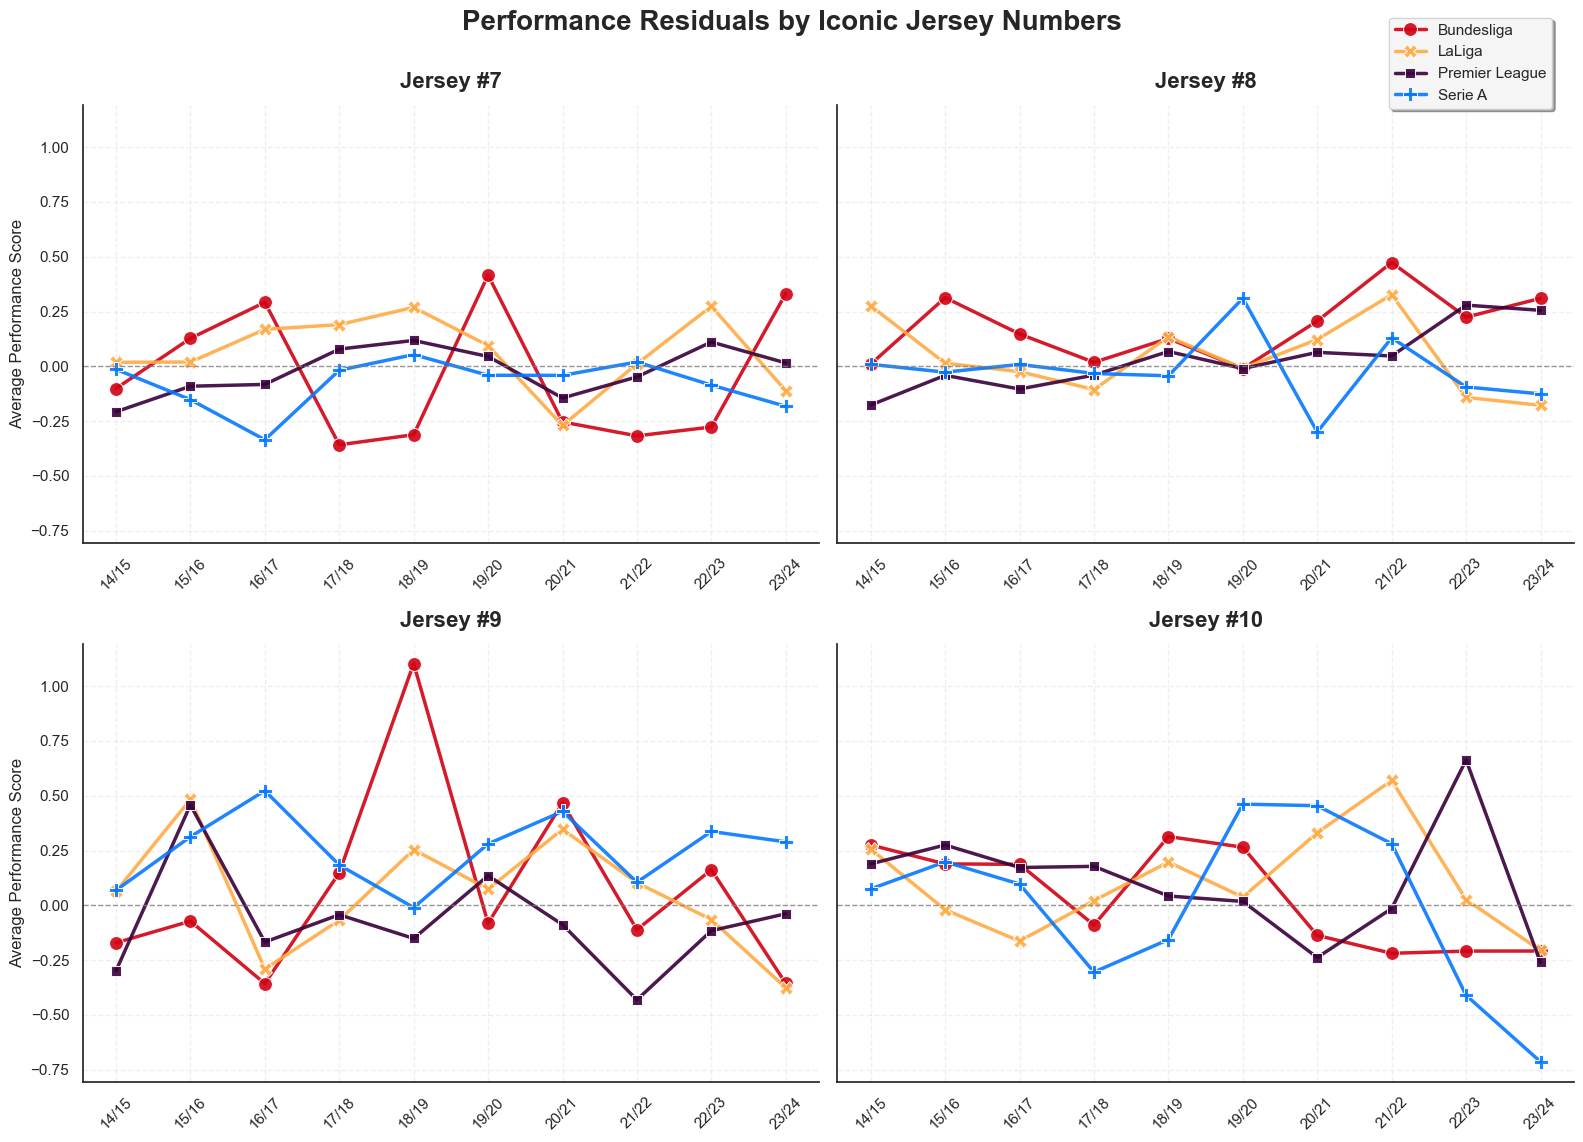

In [56]:
iconic_jersey_nums = curbles_filtered_df[curbles_filtered_df['jersey_number'].isin([7,8,9,10])] \
                    .groupby(by=['competition_name', 'season', 'jersey_number'], observed=True) \
                    .agg(
                        avg_performance_score=('standardized_performance_residual', 'mean'),
                        observation_count=('standardized_performance_residual', 'count')
).reset_index()


fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
fig.suptitle('Performance Residuals by Iconic Jersey Numbers', 
             fontsize=20, fontweight='bold', y=0.95)

for i, number in enumerate([7, 8, 9, 10]):
    ax = axes[i//2, i%2]
    subset = iconic_jersey_nums[iconic_jersey_nums['jersey_number'] == number]

    sns.lineplot(
        data=subset,
        x='season',
        y='avg_performance_score',
        hue='competition_name',
        style='competition_name',
        markers=True,
        dashes=False,
        markersize=10,
        linewidth=2.5,
        alpha=0.9,
        palette=competition_colors,
        ax=ax
    )

    ax.axhline(0, color='gray', linestyle='--', alpha=0.8, linewidth=1)
    ax.set_title(f'Jersey #{number}', fontsize=16, fontweight='bold', pad=12)
    ax.set_xlabel('')
    ax.set_ylabel('Average Performance Score', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,
           title='',
           loc='upper right',
           bbox_to_anchor=(0.98, 0.95),
           frameon=True,
           framealpha=0.9,
           shadow=True)
for ax in axes.flat:
    ax.get_legend().remove()


plt.tight_layout(rect=[0, 0, 1, 0.95])
sns.despine()
plt.show()

In [57]:
def standardize_club_names(df):
    df = df.copy()

    club_mapping = (
        df.groupby(['club_id', 'club_name'], observed=True)
        .size()
        .reset_index(name='count')
        .sort_values(['club_id', 'count'], ascending=[True, False])
        .drop_duplicates('club_id')
        .set_index('club_id')['club_name']
        .to_dict()
    )

    # Apply the mapping to standardize all club names
    df['club_name'] = df['club_id'].map(club_mapping)

    return df


fixed_curbles_filtered_df = standardize_club_names(curbles_filtered_df)

In [58]:
jersey_stats_by_club = fixed_curbles_filtered_df.groupby(by=['club_name', 'competition_name', 'jersey_number'], observed=True).agg(
    historic_team_value=('historic_team_value', 'first'),
    avg_performance_score=('standardized_performance_residual', 'mean'),
    observation_count=('standardized_performance_residual', 'count'),
).reset_index()

custom_bins = [0, 11, 25, np.inf]
bin_labels = ['1-11', '12-25', '26+']

jersey_stats_by_club['jersey_num_bins'] = pd.cut(
    jersey_stats_by_club['jersey_number'], bins=custom_bins, labels=bin_labels
)

# Creating a score that's adjusted for observation count
jersey_stats_by_club['observation_count'] = jersey_stats_by_club['observation_count'].astype('int')
jersey_stats_by_club['consolidated_score'] = jersey_stats_by_club['avg_performance_score'] * jersey_stats_by_club['observation_count']

display(jersey_stats_by_club[jersey_stats_by_club['club_name'] == 'Arsenal FC'])

club_name competition_name  jersey_number  historic_team_value  \
598  Arsenal FC   Premier League              1            20.236173   
599  Arsenal FC   Premier League              2            20.236173   
600  Arsenal FC   Premier League              3            20.236173   
601  Arsenal FC   Premier League              4            20.236173   
602  Arsenal FC   Premier League              5            20.236173   
..          ...              ...            ...                  ...   
654  Arsenal FC   Premier League             77            20.236173   
655  Arsenal FC   Premier League             78            20.236173   
656  Arsenal FC   Premier League             85            20.236173   
657  Arsenal FC   Premier League             87            20.236173   
658  Arsenal FC   Premier League             96            20.236173   

     avg_performance_score  observation_count jersey_num_bins  \
598              -0.399362                  7            1-11   
599              -0.030023                  8            1-11   
600               0.077572                  7            1-11   
601               -0.40278                  9            1-11   
602               0.052606                  8            1-11   
..                     ...                ...             ...   
654               1.551429                  1             26+   
655               0.301004                  1             26+   
656              -0.769437                  1             26+   
657               1.200272                  1             26+   
658              -0.801017                  1             26+   

     consolidated_score  
598           -2.795532  
599           -0.240181  
600            0.543005  
601           -3.625016  
602            0.420848  
..                  ...  
654            1.551429  
655            0.301004  
656           -0.769437  
657            1.200272  
658           -0.801017  

[61 rows x 8 columns]

In [59]:
def create_jersey_number_heatmap(df, color_palette, max_jersey_number=25, title=""):
    """
    Creates a horizontal stripplot visualization of consolidated scores by jersey number.

    Parameters:
    df (DataFrame): Filtered dataframe with columns 'consolidated_score', 'jersey_number', and 'club_name'
    color_palette (dict): Color mapping for the hue values
    max_jersey_number (int): Maximum jersey number to display (default: 25)
    title (str): Chart title
    """

    # Filter data to specified jersey number range
    filtered_df = df[df['jersey_number'] <= max_jersey_number]

    # Create the visualization
    # plt.figure(figsize=figsize)
    g = sns.PairGrid(filtered_df,
                     x_vars=['consolidated_score'],
                     y_vars=['jersey_number'],
                     hue='club_name',
                     palette=color_palette,
                     height=11,
                     aspect=.45,
                    )

    g.map(sns.stripplot,
          size=11,
          orient="h",
          jitter=False,
          linewidth=1,
          edgecolor="black",
          alpha=1)

    g.set(xlabel='Average Consolidated Score', ylabel='')
    if title:
        g.fig.suptitle(title, fontsize=15, weight='bold', y=1.01)
    for ax in g.axes.flat:
        ax.set_yticks(range(0, max_jersey_number+1))
        ax.set_yticklabels(ax.get_yticklabels(),
                           fontstyle='italic',
                           fontweight='bold',
                           fontsize=12)

        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    plt.axvline(0, color='gray', linestyle=':', alpha=0.4, linewidth=1)

    g.add_legend(title="", label_order=df['club_name'].unique(), bbox_to_anchor=(1.02, 0.92), frameon=True, shadow=True)
    g.legend.get_frame().set_facecolor('#FFFFFF')
    g.legend.get_title().set_fontsize(12)

    plt.figtext(0.43, 0.004, "Consolidated Score = Residual × Observation Count", ha='center', fontsize=10, fontstyle='italic', color='#555555')

    sns.despine(left=True, bottom=True)
    plt.show()

##### Heatmaps for Big Rivalries

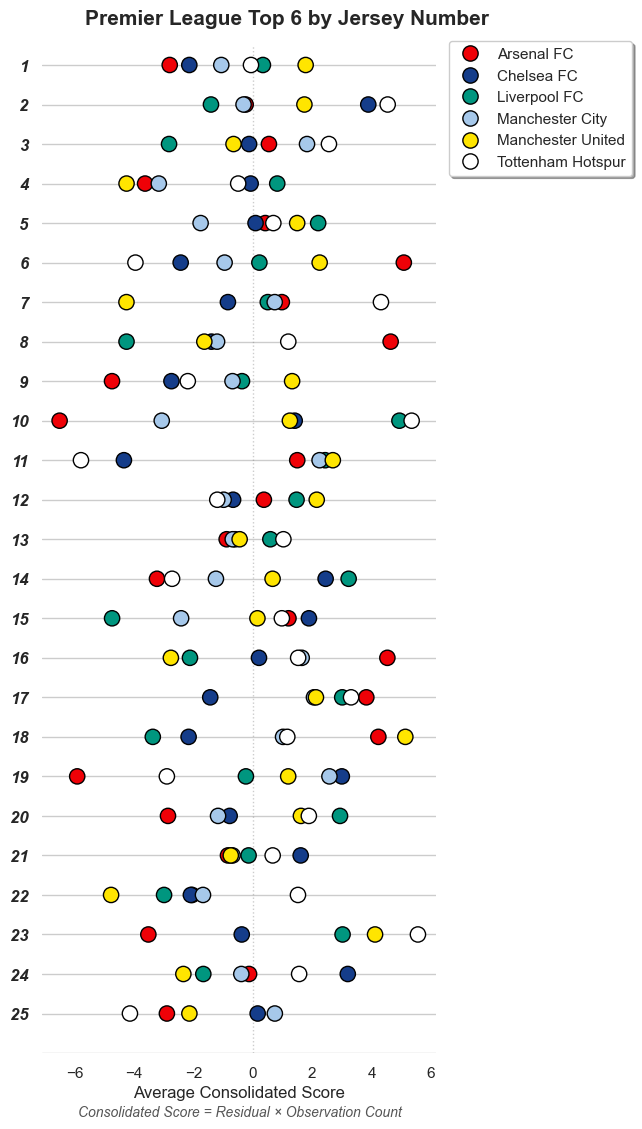

In [60]:
'''
Premier League Rivalries
'''
topsix_colors = {
    'Arsenal FC': '#EF0107',
    'Chelsea FC': '#153D8A',
    'Tottenham Hotspur': '#FFFFFF',
    'Manchester United': '#FFE500',
    'Manchester City': '#A6C8EA',
    'Liverpool FC': '#00967F',
}

topsix = jersey_stats_by_club[jersey_stats_by_club['club_name'].isin(topsix_colors.keys())]

create_jersey_number_heatmap(
    df=topsix,
    color_palette=topsix_colors,
    title="Premier League Top 6 by Jersey Number",
)

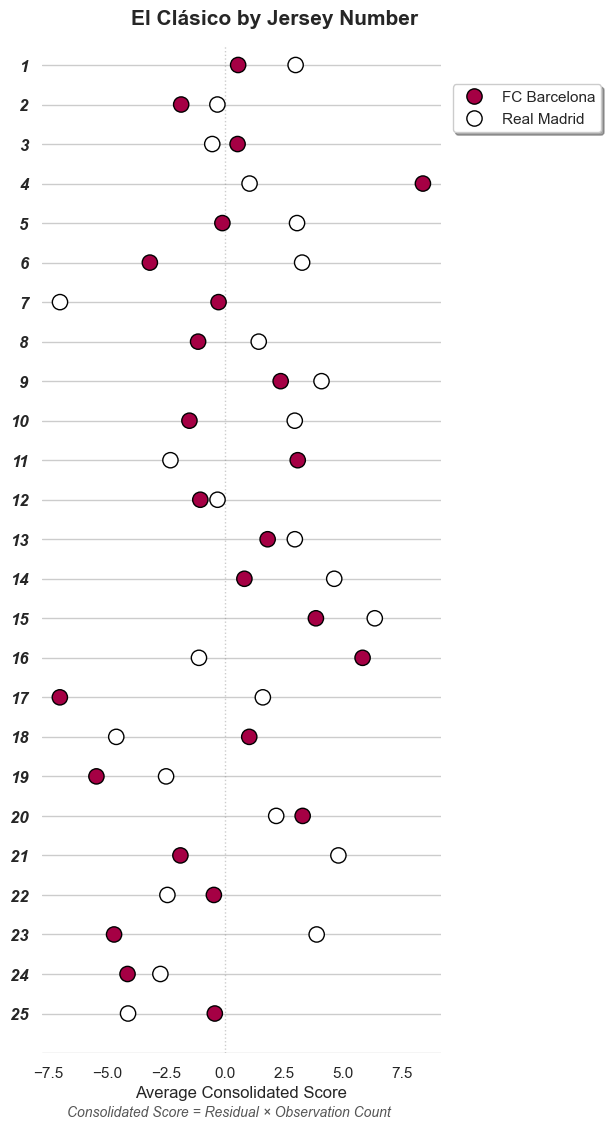

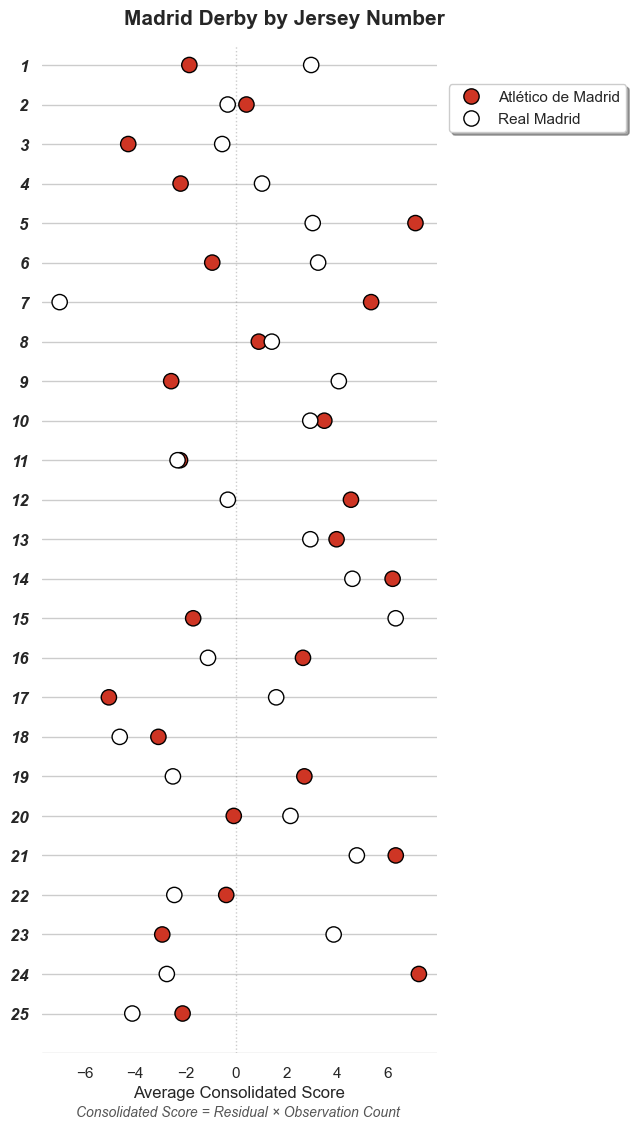

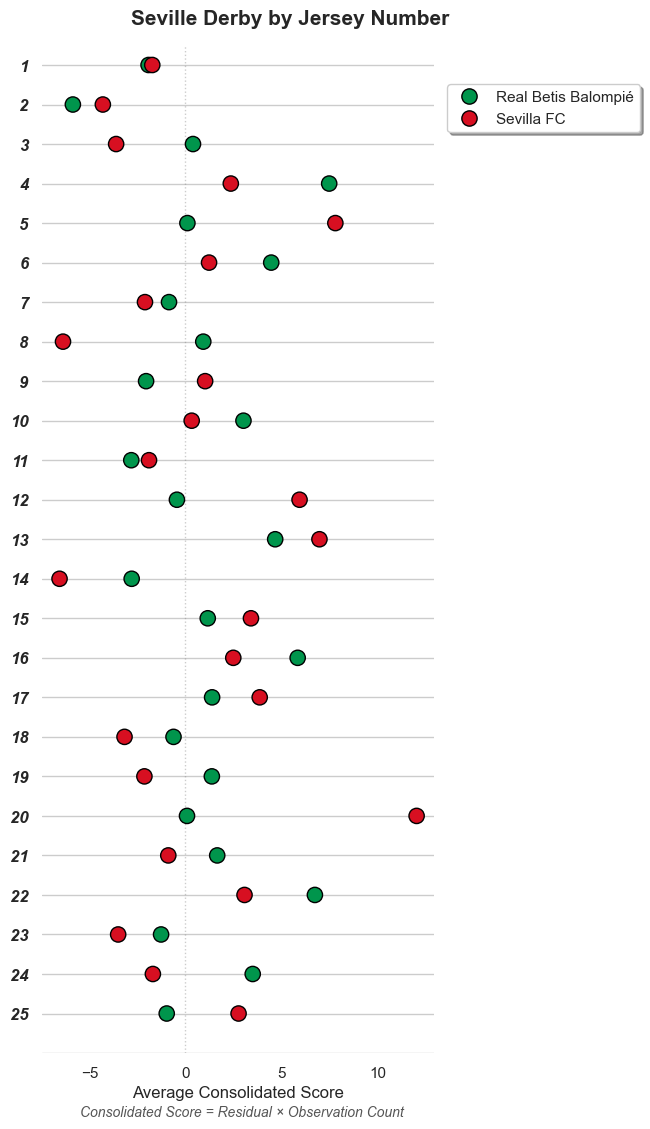

In [61]:
'''
LaLiga Rivalries
'''
elclassico_colors = {
    'FC Barcelona': '#A50044',
    'Real Madrid': '#FFFFFF'
}
elclassico = jersey_stats_by_club[jersey_stats_by_club['club_name'].isin(elclassico_colors.keys())]

create_jersey_number_heatmap(
    df=elclassico,
    color_palette=elclassico_colors,
    title="El Clásico by Jersey Number",
)


madridderby_colors = {
    'Atlético de Madrid': '#CE3524',
    'Real Madrid': '#FFFFFF'
}
madridderby = jersey_stats_by_club[jersey_stats_by_club['club_name'].isin(madridderby_colors.keys())]

create_jersey_number_heatmap(
    df=madridderby,
    color_palette=madridderby_colors,
    title="Madrid Derby by Jersey Number",
)


sevillederby_colors = {
    'Sevilla FC': '#D70F21',
    'Real Betis Balompié': '#00954C'
}
sevillederby = jersey_stats_by_club[jersey_stats_by_club['club_name'].isin(sevillederby_colors.keys())]

create_jersey_number_heatmap(
    df=sevillederby,
    color_palette=sevillederby_colors,
    title="Seville Derby by Jersey Number",
)

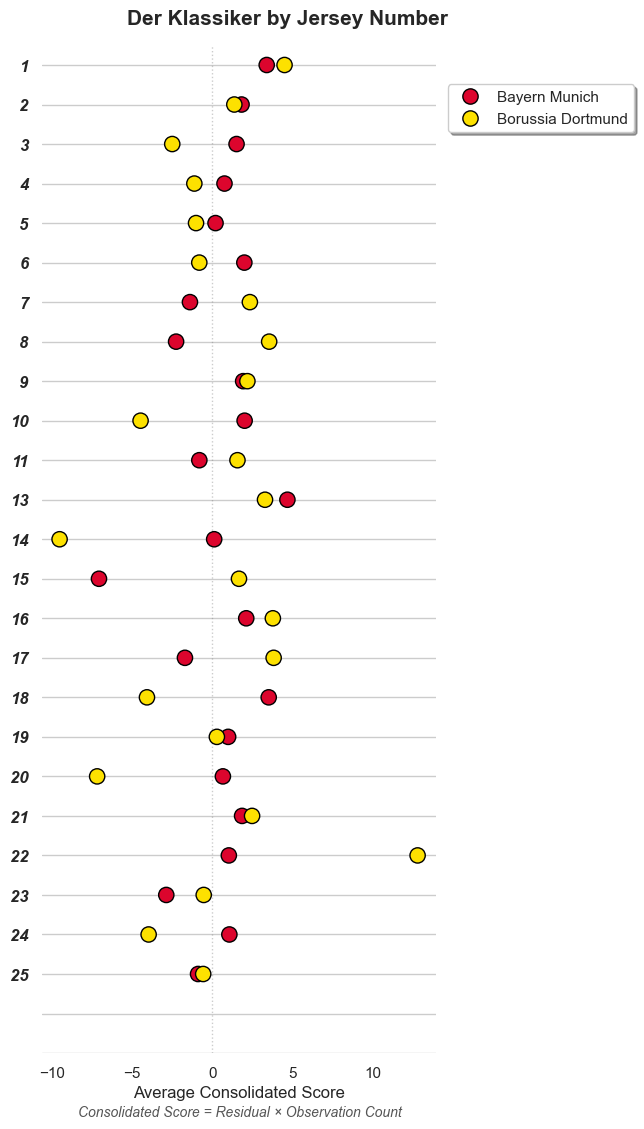

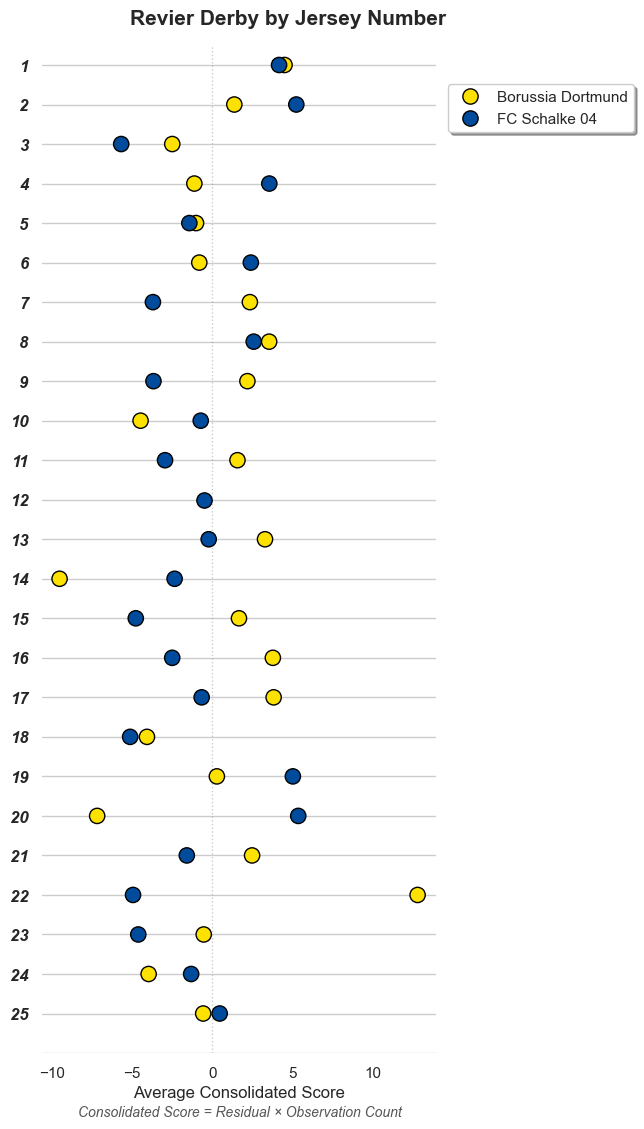

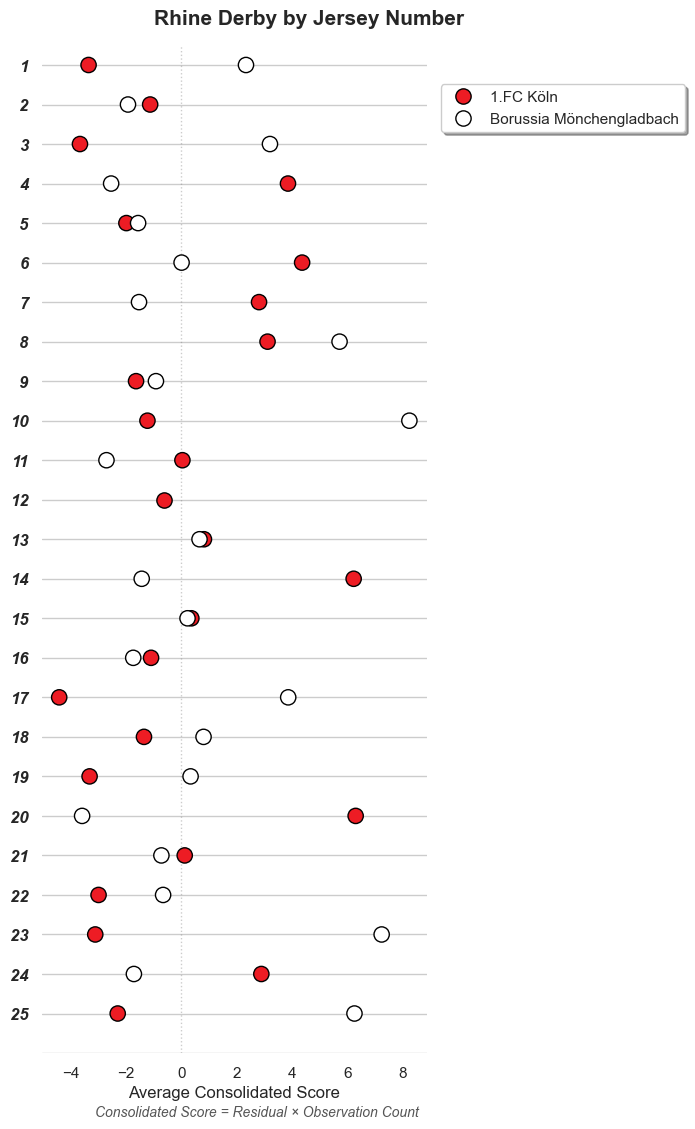

In [62]:
'''
Bundesliga Rivalries
'''
derklassiker_colors = {
    'Borussia Dortmund': '#FDE100',
    'Bayern Munich': '#DC052D'
}
derklassiker = jersey_stats_by_club[jersey_stats_by_club['club_name'].isin(derklassiker_colors.keys())]

create_jersey_number_heatmap(
    df=derklassiker,
    color_palette=derklassiker_colors,
    title="Der Klassiker by Jersey Number",
)


revierderby_colors = {
    'Borussia Dortmund': '#FDE100',
    'FC Schalke 04': '#004B9C'
}
revierderby = jersey_stats_by_club[jersey_stats_by_club['club_name'].isin(revierderby_colors.keys())]

create_jersey_number_heatmap(
    df=revierderby,
    color_palette=revierderby_colors,
    title="Revier Derby by Jersey Number",
)


rhinederby_colors = {
    '1.FC Köln': '#ED1C24',
    'Borussia Mönchengladbach': '#FFFFFF'
}
rhinederby = jersey_stats_by_club[jersey_stats_by_club['club_name'].isin(rhinederby_colors.keys())]

create_jersey_number_heatmap(
    df=rhinederby,
    color_palette=rhinederby_colors,
    title="Rhine Derby by Jersey Number",
)

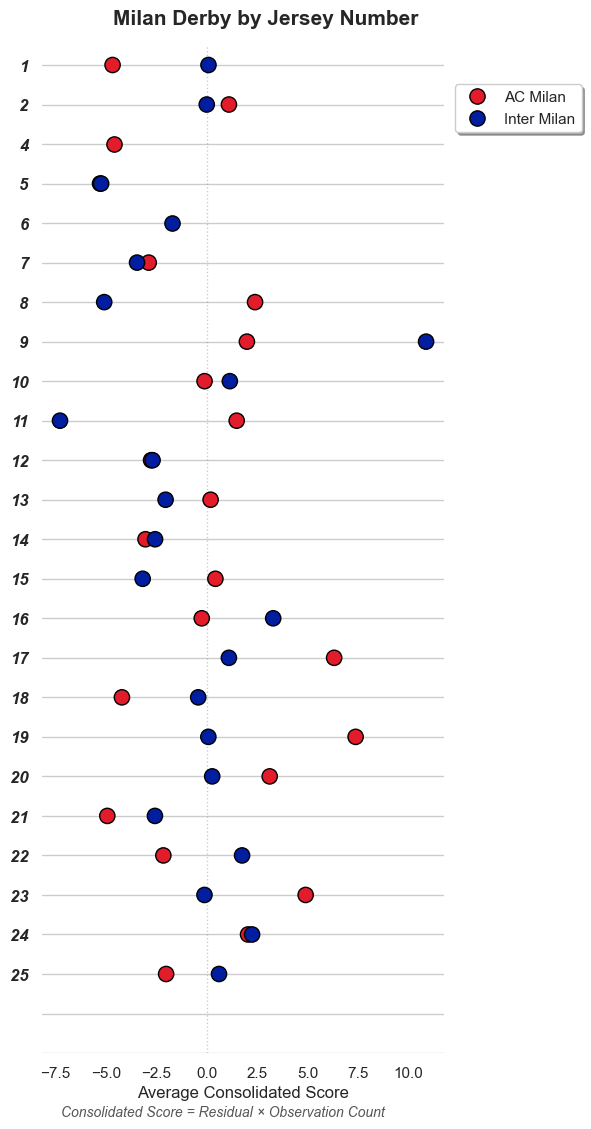

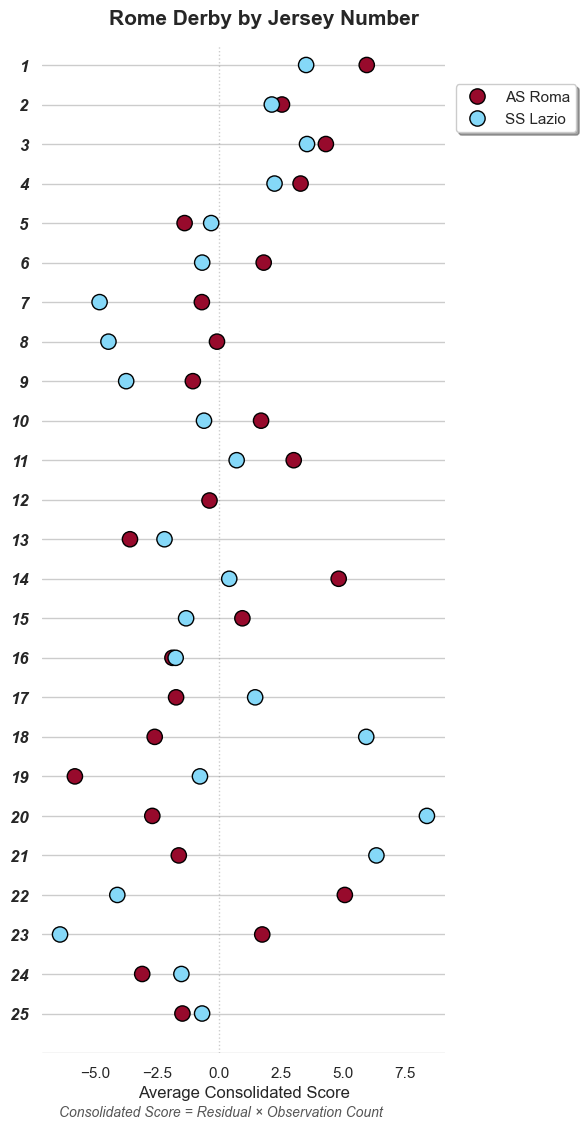

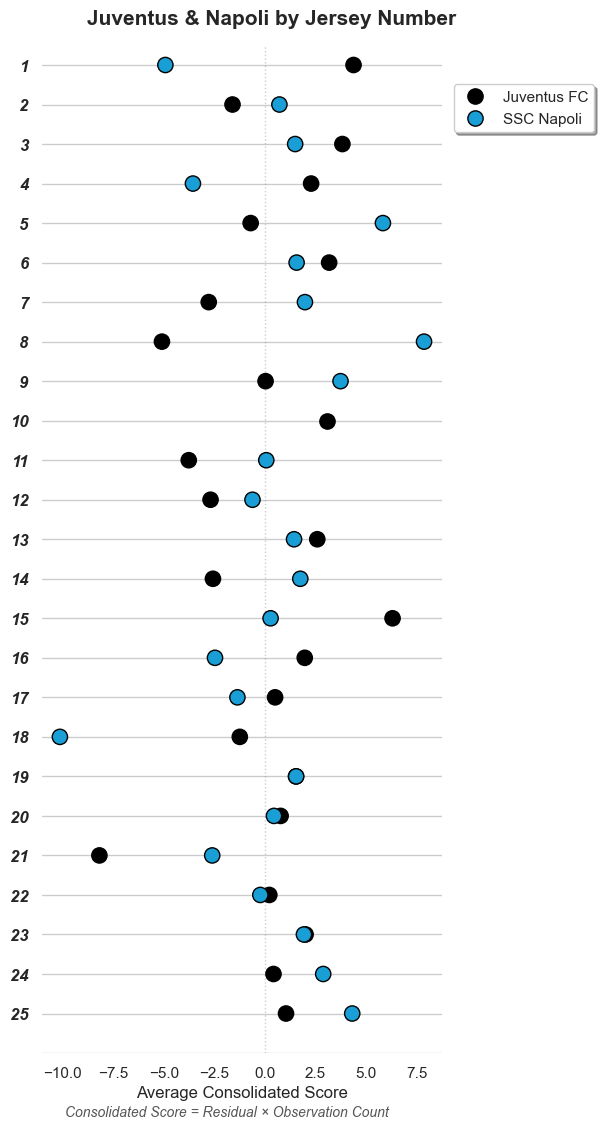

In [63]:
'''
Serie A Rivalries
'''
milanderby_colors = {
    'Inter Milan': '#011EA0',
    'AC Milan': '#E21C2A'
}
milanderby = jersey_stats_by_club[jersey_stats_by_club['club_name'].isin(milanderby_colors.keys())]

create_jersey_number_heatmap(
    df=milanderby,
    color_palette=milanderby_colors,
    title="Milan Derby by Jersey Number",
)


romederby_colors = {
    'AS Roma': '#970A2C',
    'SS Lazio': '#85D8F8'
}
romederby = jersey_stats_by_club[jersey_stats_by_club['club_name'].isin(romederby_colors.keys())]

create_jersey_number_heatmap(
    df=romederby,
    color_palette=romederby_colors,
    title="Rome Derby by Jersey Number",
)


juvandnapoli_colors = {
    'Juventus FC': '#000000',
    'SSC Napoli': '#199FD6'
}
juvandnapoli = jersey_stats_by_club[jersey_stats_by_club['club_name'].isin(juvandnapoli_colors.keys())]

create_jersey_number_heatmap(
    df=juvandnapoli,
    color_palette=juvandnapoli_colors,
    title="Juventus & Napoli by Jersey Number",
)

##### Rest of Club-wide Analysis

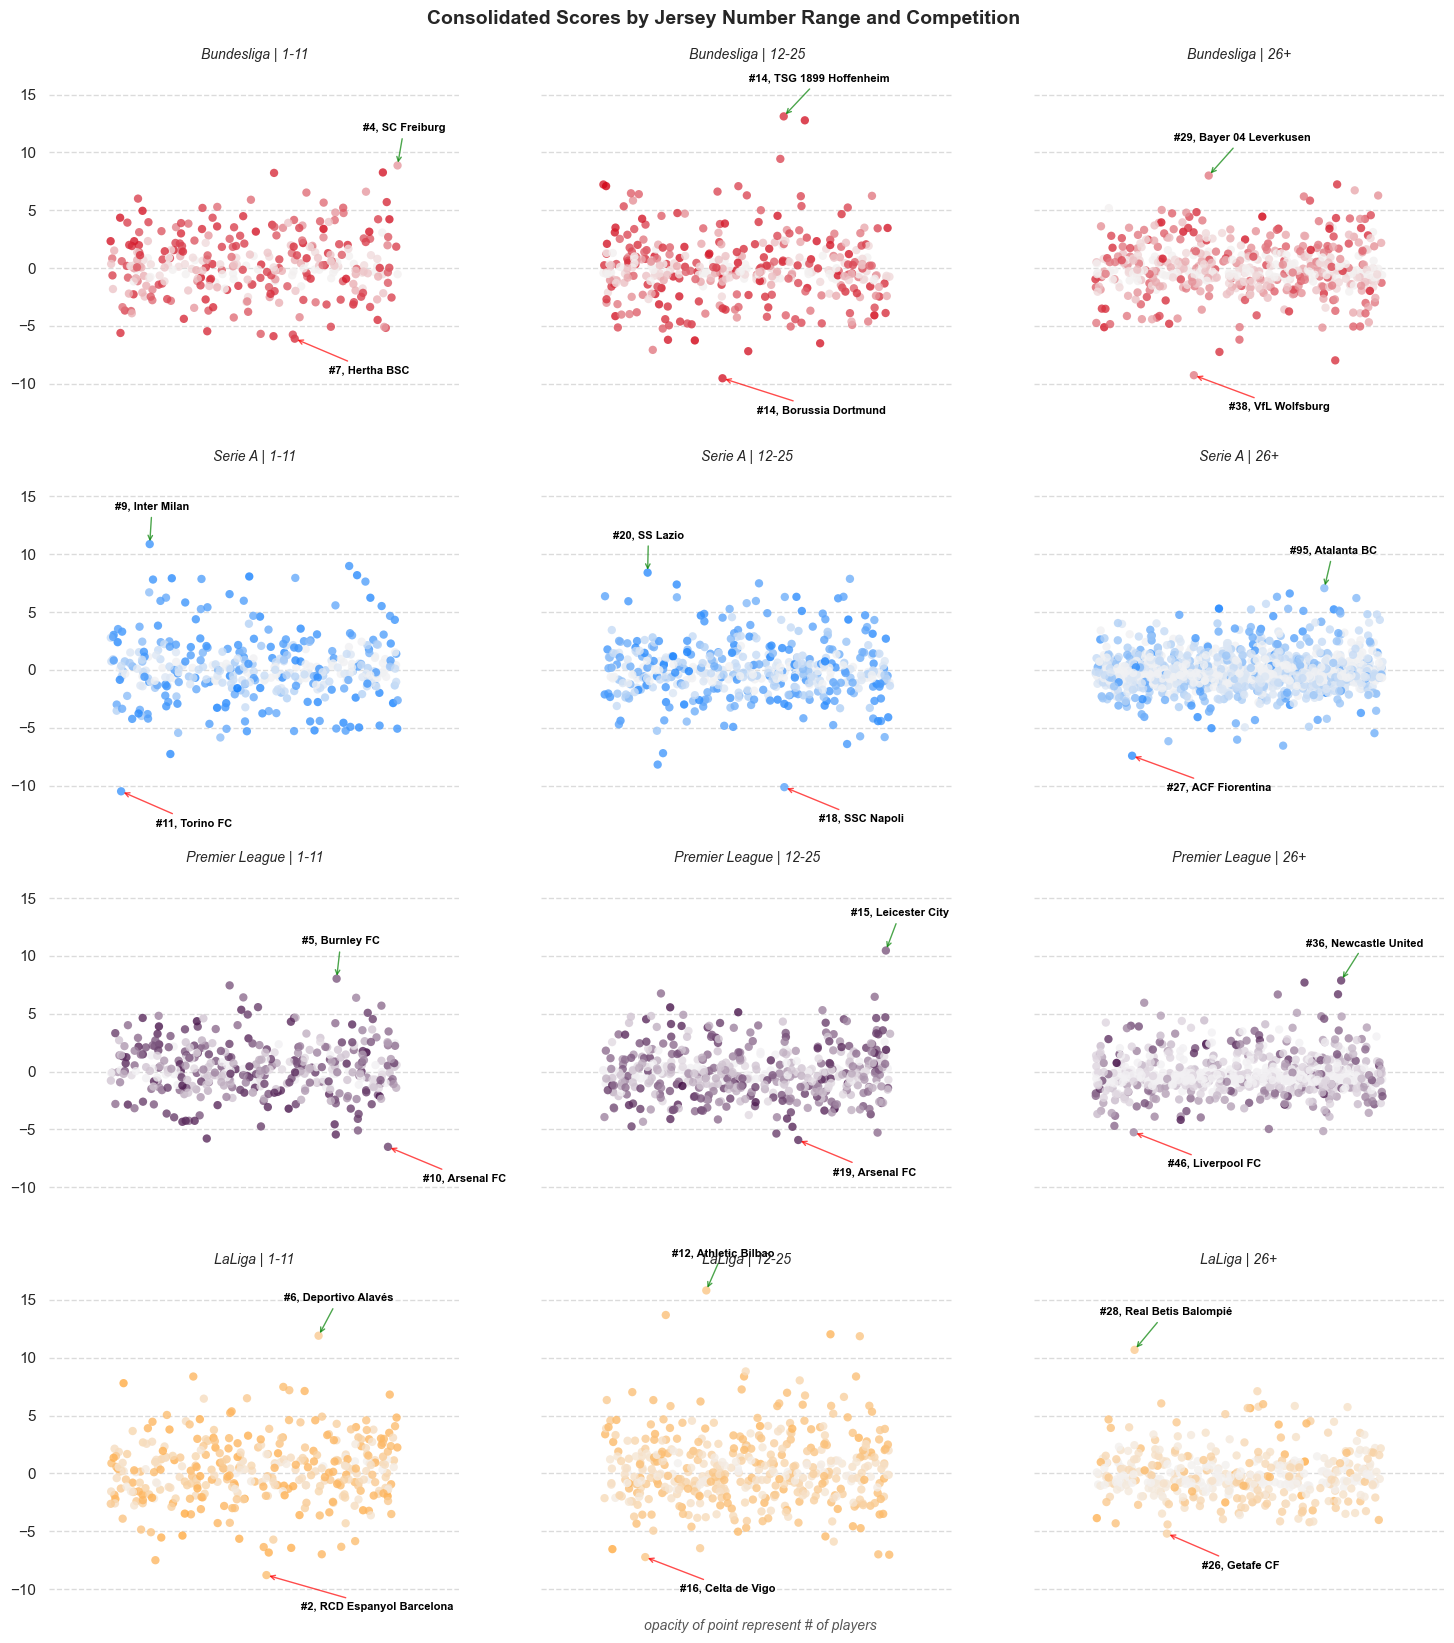

In [64]:
fig, axes = plt.subplots(4, 3, figsize=(18, 20), sharey=True)


jersey_bins = jersey_stats_by_club['jersey_num_bins'].unique()
competitions = jersey_stats_by_club['competition_name'].unique()

global_min = jersey_stats_by_club['consolidated_score'].min()
global_max = jersey_stats_by_club['consolidated_score'].max()

for i, comp in enumerate(competitions):
    for j, j_bin in enumerate(jersey_bins):
        ax = axes[i, j]

        # Filter data for this subplot
        subset = jersey_stats_by_club[
            (jersey_stats_by_club['competition_name'] == comp) &
            (jersey_stats_by_club['jersey_num_bins'] == j_bin)
        ].copy().reset_index(drop=True)

        sns.stripplot(
            data=subset,
            y='consolidated_score',
            hue='observation_count',
            palette=sns.light_palette(competition_colors[comp], as_cmap=True),
            size=6,
            jitter=0.35,
            alpha=0.8,
            ax=ax
        )

        # Remove individual legends
        ax.get_legend().remove()

        # Customize subplot
        ax.set_title(f"{comp} | {j_bin}", fontsize=10, pad=8, style='italic')
        ax.set_xlabel("")
        ax.set_ylabel('')
        ax.set_ylim(global_min - 0.05*(global_max-global_min), 
                   global_max + 0.05*(global_max-global_min))
        sns.despine(ax=ax, left=True, bottom=True)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Get point coordinates from the plot
        points = ax.collections[0]
        coords = points.get_offsets().data

        # Find top 2 and bottom 2 values
        top2 = subset.nlargest(1, 'consolidated_score')
        bottom2 = subset.nsmallest(1, 'consolidated_score')
        for _, row in top2.iterrows():
            idx = subset[subset.index == row.name].index[0]
            x, y = coords[idx]
            ax.annotate(f"#{int(row['jersey_number'])}, {row['club_name']}", 
                       (x, y), 
                       xytext=(-25, 25),  # Offset to the right
                       textcoords='offset points',
                       fontsize=8,
                       fontweight='bold',
                       color='black',
                       arrowprops=dict(arrowstyle='->', color='green', alpha=0.7))


        for _, row in bottom2.iterrows():
            idx = subset[subset.index == row.name].index[0]
            x, y = coords[idx]
            ax.annotate(f"#{int(row['jersey_number'])}, {row['club_name']}", 
                       (x, y), 
                       xytext=(25, -25),  # Offset to the right and down
                       textcoords='offset points',
                       fontsize=8,
                       fontweight='bold',
                       color='black',
                       arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))

fig.suptitle('Consolidated Scores by Jersey Number Range and Competition', y=0.91, fontsize=14, fontweight='bold')
plt.figtext(0.52, 0.1, "opacity of point represent # of players", ha='center', fontsize=10, fontstyle='italic', color='#555555')

plt.show()

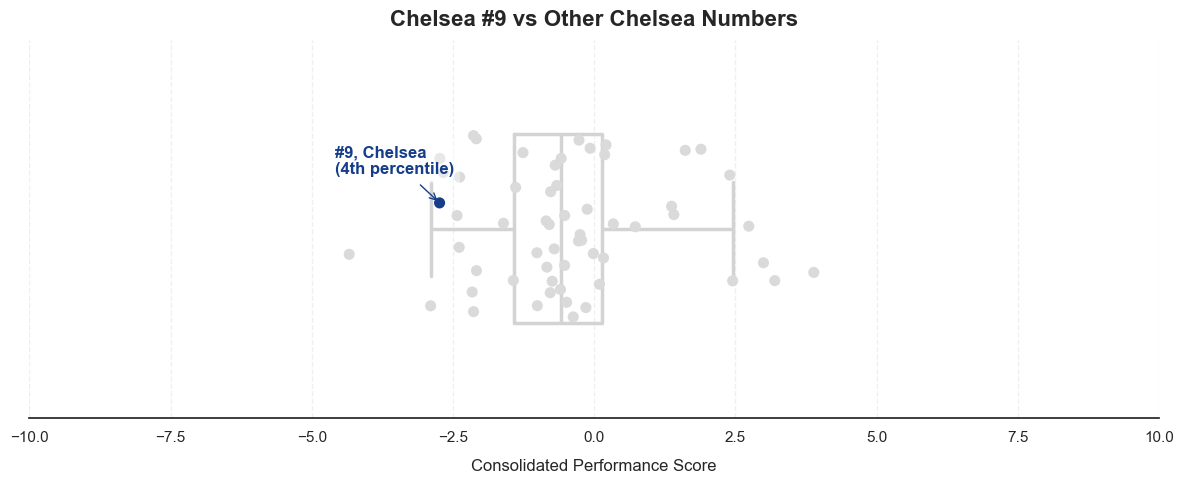

In [79]:
jersey_stats_by_club['team_is_chelsea'] = (jersey_stats_by_club['club_name'] == 'Chelsea FC')
jersey_stats_by_club['is_num_nine'] = (jersey_stats_by_club['jersey_number'] == 9)

chelsea_nums = jersey_stats_by_club[jersey_stats_by_club['team_is_chelsea']].reset_index()

plt.figure(figsize=(12, 5))

boxplot = sns.boxplot(
    data=chelsea_nums,
    x='consolidated_score',
    color='lightgray',
    width=.5,
    linewidth=2.5,
    fill=None,
    fliersize=0,
)

stripplot = sns.stripplot(
    data=chelsea_nums,
    x='consolidated_score',
    hue='is_num_nine',
    legend=None,
    marker='o',
    palette=['#DADADA', '#153D8A'],
    size=8,
    jitter=0.25,
    alpha=1,
    edgecolor='white',
)

all_scores = chelsea_nums['consolidated_score'].to_numpy()
chelsea_point = chelsea_nums[chelsea_nums['is_num_nine']]
percentile_rank = stats.percentileofscore(all_scores, chelsea_point['consolidated_score'].values[0], kind='mean')

points = stripplot.collections[0]
coords = points.get_offsets().data

idx = chelsea_point.index[0]
x, y = coords[idx]
plt.annotate(f"#9, Chelsea\n({percentile_rank:.0f}th percentile)",
             (x, y),
             xytext=(-75, 30),
             textcoords='offset points',
             fontsize=12,
             fontweight='bold',
             color='#153D8A',
             va='center',
             bbox=dict(facecolor='white', alpha=0.4, pad=4, edgecolor='none'),
             arrowprops=dict(arrowstyle='->', color='#153D8A', alpha=1))


plt.title('Chelsea #9 vs Other Chelsea Numbers', fontsize=16, pad=10, fontweight='bold')
plt.xlabel('Consolidated Performance Score', fontsize=12, labelpad=10)

plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=True)
plt.tight_layout()
plt.show()

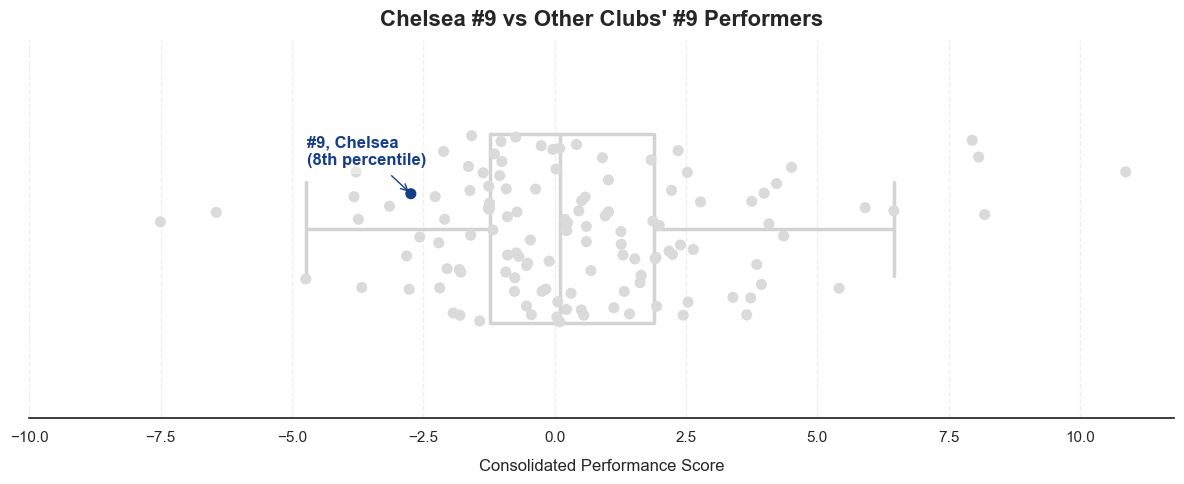

In [83]:
all_num9s = jersey_stats_by_club[jersey_stats_by_club['is_num_nine']].reset_index()


plt.figure(figsize=(12, 5))

boxplot = sns.boxplot(
    data=all_num9s,
    x='consolidated_score',
    color='lightgray',
    width=.5,
    linewidth=2.5,
    fill=None,
    fliersize=0,
)

stripplot = sns.stripplot(
    data=all_num9s,
    x='consolidated_score',
    hue='team_is_chelsea',
    legend=None,
    marker='o',
    palette=['#DADADA', '#153D8A'],
    size=8,
    jitter=0.25,
    alpha=1,
    edgecolor='white',
)

all_scores = all_num9s['consolidated_score'].to_numpy()
chelsea_point = all_num9s[all_num9s['team_is_chelsea']]
percentile_rank = stats.percentileofscore(all_scores, chelsea_point['consolidated_score'].values[0], kind='mean')

points = stripplot.collections[0]
coords = points.get_offsets().data

idx = chelsea_point.index[0]
x, y = coords[idx]
plt.annotate(f"#9, Chelsea\n({percentile_rank:.0f}th percentile)",
             (x, y),
             xytext=(-75, 30),
             textcoords='offset points',
             fontsize=12,
             fontweight='bold',
             color='#153D8A',
             va='center',
             bbox=dict(facecolor='white', alpha=0.4, pad=4, edgecolor='none'),
             arrowprops=dict(arrowstyle='->', color='#153D8A', alpha=1))


plt.title('Chelsea #9 vs Other Clubs\' #9 Performers', fontsize=16, pad=10, fontweight='bold')
plt.xlabel('Consolidated Performance Score', fontsize=12, labelpad=10)

plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=True)
plt.tight_layout()
plt.show()

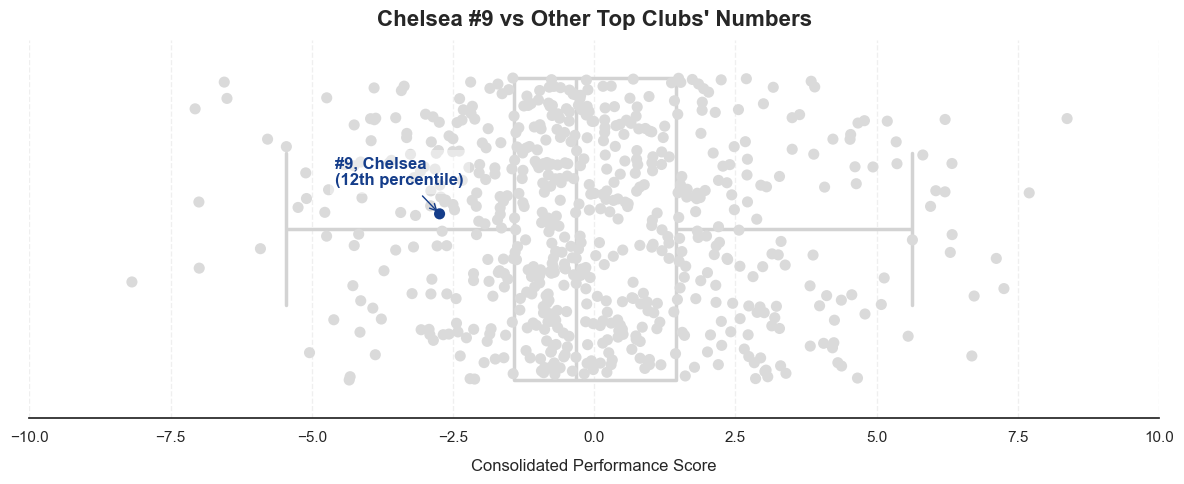

In [82]:
top_clubs = jersey_stats_by_club[jersey_stats_by_club['historic_team_value'] >= 20].reset_index()
top_clubs['is_num_9_and_chelsea'] = (top_clubs['is_num_nine'] & top_clubs['team_is_chelsea'])


plt.figure(figsize=(12, 5))

boxplot = sns.boxplot(
    data=top_clubs,
    x='consolidated_score',
    color='lightgray',
    width=.8,
    linewidth=2.5,
    fill=None,
    fliersize=0,
)

stripplot = sns.stripplot(
    data=top_clubs,
    x='consolidated_score',
    hue='is_num_9_and_chelsea',
    legend=None,
    marker='o',
    palette=['#DADADA', '#153D8A'],
    size=8,
    jitter=0.4,
    alpha=1,
    edgecolor='white',
)

all_scores = top_clubs['consolidated_score'].to_numpy()
chelsea_point = top_clubs[(top_clubs['team_is_chelsea']) & (top_clubs['jersey_number'] == 9)]
percentile_rank = stats.percentileofscore(all_scores, chelsea_point['consolidated_score'].values[0], kind='mean')

points = stripplot.collections[0]
coords = points.get_offsets().data

idx = chelsea_point.index[0]
x, y = coords[idx]
plt.annotate(f"#9, Chelsea\n({percentile_rank:.0f}th percentile)",
             (x, y),
             xytext=(-75, 30),
             textcoords='offset points',
             fontsize=12,
             fontweight='bold',
             color='#153D8A',
             va='center',
             bbox=dict(facecolor='white', alpha=0.4, pad=4, edgecolor='none'),
             arrowprops=dict(arrowstyle='->', color='#153D8A', alpha=1))


plt.title('Chelsea #9 vs Other Top Clubs\' Numbers', fontsize=16, pad=10, fontweight='bold')
plt.xlabel('Consolidated Performance Score', fontsize=12, labelpad=10)

plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=True)
plt.tight_layout()
plt.show()

In [68]:
cursed_blessed_df = pd.concat(
    [jersey_stats_by_club.loc[jersey_stats_by_club.groupby('club_name')['consolidated_score'].idxmax()],
    jersey_stats_by_club.loc[jersey_stats_by_club.groupby('club_name')['consolidated_score'].idxmin()]],
    ignore_index=True
).sort_values(by=['competition_name'])


temp_score_distance_merge = cursed_blessed_df.groupby('club_name')['consolidated_score'].agg(
    score_distance=lambda x: x.max() - x.min()
).reset_index()
cursed_blessed_df = cursed_blessed_df.merge(temp_score_distance_merge, on='club_name', how='left') \
                                     .sort_values(by=['competition_name', 'score_distance'], ascending=[True, False])

display(cursed_blessed_df[cursed_blessed_df['club_name'] == 'Borussia Dortmund'])

club_name competition_name  jersey_number  historic_team_value  \
39  Borussia Dortmund       Bundesliga             14            19.952546   
48  Borussia Dortmund       Bundesliga             22            19.952546   

    avg_performance_score  observation_count jersey_num_bins  \
39              -0.951731                 10           12-25   
48                1.27774                 10           12-25   

    consolidated_score  team_is_chelsea  is_num_nine  score_distance  
39           -9.517305            False        False       22.294702  
48           12.777396            False        False       22.294702

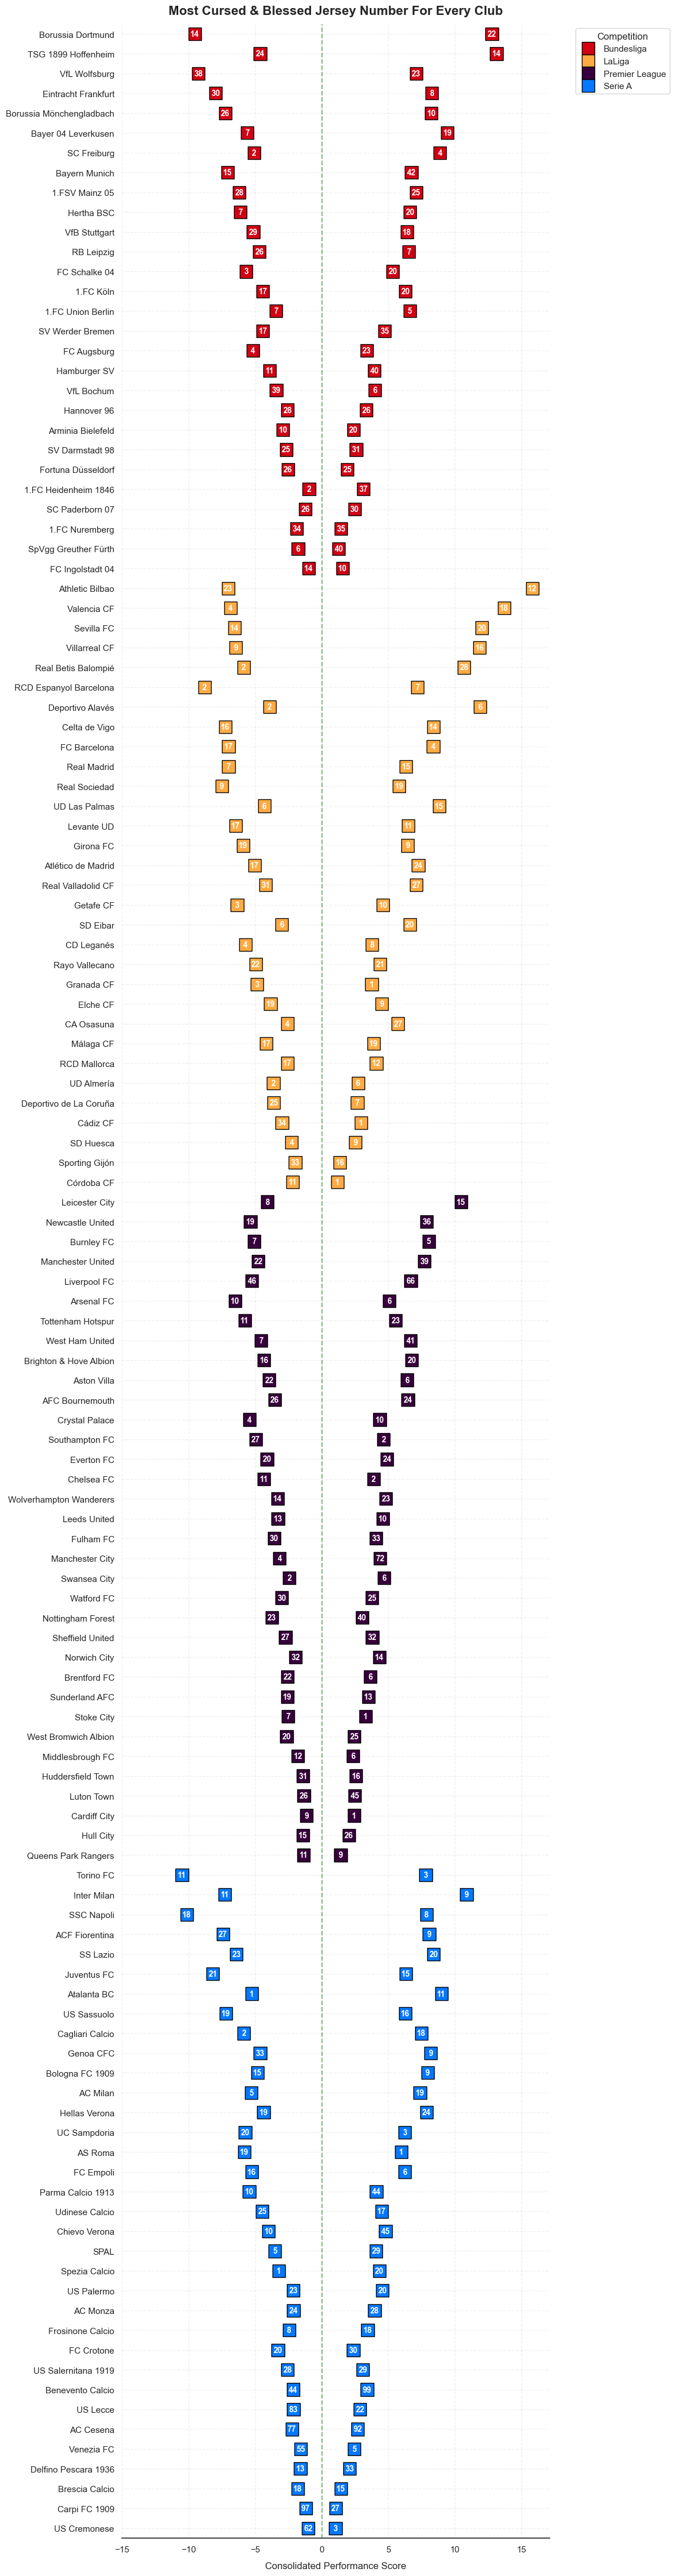

In [69]:
figsize = (12, 45)

# Visualization 1: Blessed Jerseys
plt.figure(figsize=figsize)
ax = sns.stripplot(
    data=cursed_blessed_df,
    x='consolidated_score',
    y='club_name',
    hue='competition_name',
    palette=competition_colors,
    s=16,
    marker='s',
    alpha=1,
    edgecolor='black',
    linewidth=1,
    jitter=0,
    dodge=False
)

# Add jersey numbers inside squares (white text)
for idx, row in cursed_blessed_df.iterrows():
    ax.text(
        row['consolidated_score'],
        row['club_name'],
        f"{int(row['jersey_number'])}",
        fontsize=10,
        color='white',
        va='center',
        ha='center',
        fontweight='bold'
    )

# Enhance aesthetics
plt.title('Most Cursed & Blessed Jersey Number For Every Club', fontsize=16, pad=12, fontweight='bold')
plt.xlabel('Consolidated Performance Score', fontsize=12, labelpad=10)
plt.ylabel('', fontsize=12, labelpad=10)
plt.grid(True, linestyle='--', alpha=0.3)
plt.axvline(0, color='green', linestyle='--', alpha=0.5)
plt.xticks(range(-15, 16, 5))
plt.legend(title='Competition', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine(left=True)
plt.tight_layout()
plt.show()

In [84]:
display(curbles_df[(curbles_df['jersey_number'] == 9) & (curbles_df['club_name'] == 'Chelsea FC')] \
                        .sort_values('standardized_performance_residual', ascending=False) \
                        .style.format({"starting_mv": "{:,.0f}", "sum_total_changes": "{:,.0f}"}))